# Analyse de Survie en Python 

In [48]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
from codecarbon import EmissionsTracker
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from io import StringIO
import sys

c:\Users\zergu\.conda\envs\venv\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
# Pour calculer l'energie consommée
tracker = EmissionsTracker()
tracker.start()
# le code normale
tracker.stop()

In [ ]:
tache = ['Chargement imports', 'Chargement cancer', 'Chargement expression data', 'Chargement annotations biocliniques', 
         'Chargement liste 605 gènes', 'FC+FDR pour (gène,dataset,soustype)', 'Afficher volcano', 'Afficher volcano soustype',
         'Afficher 1 courbe survie']

## Import des données 

In [2]:
# Fichier qui donne le type de cancer activé pour chaque échnantillon
cancer = pd.read_csv('data/Breast_cancer_subtypes_samples.csv',sep=';')

In [3]:
# Expressions data 
GSE21653 = pd.read_csv('data/expression_data_GSE21653_GSE21653_log_expression_266_samples_21887_genes.csv',sep=';')
Miller = pd.read_csv('data/expression_data_Miller-2005_Miller-2005_log_expression_251_samples_14145_genes.csv',sep=';')
Naderi_Caldas = pd.read_csv('data/expression_data_Naderi-Caldas-2007_Naderi-Caldas-2007_log_expression_242_samples_14366_genes.csv',sep=';')
E_MTAB_365 = pd.read_csv('data/expression_data_probreast_microarrays_E-MTAB-365_log_expression_1190_samples_23035_genes.csv',sep=';')
GSE25066 = pd.read_csv('data/expression_data_probreast_microarrays_GSE25066_log_expression_508_samples_13815_genes.csv',sep=';')
GSE42568 = pd.read_csv('data/expression_data_probreast_microarrays_GSE42568_log_expression_121_samples_23035_genes.csv',sep=';')
TCGA_BRCA = pd.read_csv('data/expression_data_tcga_brca_TCGA-BRCA_log_fpkm_1250_samples_42851_genes.csv',sep=';')
Yau = pd.read_csv('data/expression_data_Yau-2010_Yau-2010_log_expression_683_samples_8791_genes.csv',sep=';')

In [4]:
# Annotations biocliniques
GSE21653_EG = pd.read_excel('data/EpiMed_experimental_grouping_2022.11.28_GSE21653.xlsx')
GSE25066_EG = pd.read_excel('data/EpiMed_experimental_grouping_2022.11.28_GSE25066.xlsx')
GSE42568_EG = pd.read_excel('data/EpiMed_experimental_grouping_2022.11.28_GSE42568.xlsx')
TCGA_BRCA_EG = pd.read_excel('data/EpiMed_experimental_grouping_2022.11.28_TCGA-BRCA.xlsx')
Naderi_Caldas_EG = pd.read_excel('data/EpiMed_experimental_grouping_2022.12.01_Naderi-Caldas-2007.xlsx')
Yau_EG = pd.read_excel('data/EpiMed_experimental_grouping_2022.12.01_Yau-2010.xlsx')
Miller_EG = pd.read_excel('data/EpiMed_experimental_grouping_2022.12.02_Miller-2005.xlsx')
E_MTAB_365_EG = pd.read_excel('data/EpiMed_experimental_grouping_2022.11.28_E-MTAB-365.xlsx')

c:\Users\zergu\.conda\envs\venv\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\zergu\.conda\envs\venv\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\zergu\.conda\envs\venv\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\zergu\.conda\envs\venv\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\zergu\.conda\envs\venv\lib\site-packages\openpyxl\styles\stylesheet.py:

## Travail sur les 605 gènes d'intêrets

Dans la base précédente, nous avions plus de 20 000 gènes qu'il aurait fallu analyser. Nous allons réduire notre base à 605 gènes d'intêret, ils sont les plus susceptible d'être impliquer dans le développement de cancer du sein chez l'être humain. 

### Import des listes des gènes d'intêrets

Les 605 gènes d'intêrets sont contenu dans des fichiers textes. Parmi les 605 gènes d'intêrets, nous en distinguons 3 types : 

- La famille des KDM (35)
- La famille des KMT (109)
- La famille des KMB (461)

In [5]:
# Import des 35 KDM
with open("genes_interets/KDM.txt", 'r') as f:
    lignes = f.readlines()
id = eval(lignes[0].strip())
nom_gene = eval(lignes[1].strip())
KMT = pd.DataFrame({'id': id, 'nom_gene': nom_gene}) # , 'type': np.repeat("KMT",len(id))


# Import des 109 KMT
with open("genes_interets/KMT.txt", 'r') as f:
    lignes = f.readlines()
id = eval(lignes[0].strip())
nom_gene = eval(lignes[1].strip())
KDM = pd.DataFrame({'id': id, 'nom_gene': nom_gene}) # , 'type': np.repeat("KDM",len(id))

# Import des 461 KMB
with open("genes_interets/KMB.txt", 'r') as f:
    lignes = f.readlines()
id = eval(lignes[0].strip())
nom_gene = eval(lignes[1].strip())
KMB = pd.DataFrame({'id': id, 'nom_gene': nom_gene}) # , 'type': np.repeat("KMB",len(id))

Regroupons maintenant les 3 fichiers en un seul

In [6]:
GI = pd.concat([KMT,KDM,KMB])
GI.head()

,id,nom_gene
0,65990,ANTKMT
1,55870,ASH1L
2,134145,ATPSCKMT
3,144233,BCDIN3D
4,154743,BMT2


Réduction de la base : 

In [7]:
GSE21653 = GSE21653[GSE21653["id_gene"].isin(GI.id.values)]
Miller = Miller[Miller["id_gene"].isin(GI.id.values)]
Naderi_Caldas = Naderi_Caldas[Naderi_Caldas["id_gene"].isin(GI.id.values)]
E_MTAB_365 = E_MTAB_365[E_MTAB_365["id_gene"].isin(GI.id.values)]
GSE25066 = GSE25066[GSE25066["id_gene"].isin(GI.id.values)]
GSE42568 = GSE42568[GSE42568["id_gene"].isin(GI.id.values)]
TCGA_BRCA = TCGA_BRCA[TCGA_BRCA["id_gene"].isin(GI.id.values)]
Yau = Yau[Yau["id_gene"].isin(GI.id.values)]

Une fois que l'on a réduit les jeux de données à quelques centaines de gènes d'intérêts, nous intégrons le type de gènes parmi les 3 familles présentées plus tôt (KDM, KMB, KMT) dans les jeux de données (c'est une information supplémentaires qui pourra eventuellement nous servir par la suite)

In [8]:
GI.columns = ["id_gene", "nom_gene"] # , "type"

In [12]:
# Ces commandes permettent de rajouter le type de gène dans les différents jeux de données
# GSE21653 = GSE21653.merge(GI,how='left',on = 'id_gene')
# Miller = Miller.merge(GI,how='left',on = 'id_gene')
# Naderi_Caldas = Naderi_Caldas.merge(GI,how='left',on = 'id_gene')
# E_MTAB_365 = E_MTAB_365.merge(GI,how='left',on = 'id_gene')
# GSE25066 = GSE25066.merge(GI,how='left',on = 'id_gene')
# GSE42568 = GSE42568.merge(GI,how='left',on = 'id_gene')
# TCGA_BRCA = TCGA_BRCA.merge(GI,how='left',on = 'id_gene')
# Yau = Yau.merge(GI,how='left',on = 'id_gene')

## Nous pouvons dès à présent travailler sur une base réduite de gènes 

### Création du tableau comparatif pour evaluer l'expression des différents sous types moléculaires pour un gène et un échantillon donné

In [9]:
# Création de la fonction gene_expression
# Elle renvoie un tableau qui donne (pour chaque échantillon d'une jeu de données) le type de cancer ainsi que l'expression du gène donné en entrée
def gene_expression(dataset,gene,dataset2):
    TDC = cancer[cancer["Dataset"] == dataset][["Luminal-A","Luminal-B","HER2-enriched","Basal-like"]]
    ech = cancer[cancer["Dataset"] == dataset]['Sample']
    type_cancer = TDC.apply(lambda row: ''.join(row.keys()[row == 1]), axis=1)
    type_cancer = pd.DataFrame(type_cancer)
    type_cancer = type_cancer.T
    type_cancer.columns = ech.to_list()
    
    dataset2.gene_symbol = dataset2.gene_symbol.convert_dtypes()
    EG = dataset2[dataset2.gene_symbol == gene][cancer[cancer["Dataset"] == dataset]['Sample']]
    df = pd.concat([type_cancer,EG],axis=0)
    df.index = ['type', 'value']
    df = df.T
    df.value = pd.to_numeric(df.value)
    for e in ech:
        if df.loc[e].type == '' and (cancer[cancer["Sample"] == e]['All-tumours'] == 1).bool:
            df.loc[e, 'type'] = 'All-tumours'
    df['type'] = df['type'].replace({'': 'Non-tumour'})
    return df # sns.boxplot(x=df["type"],y=df["value"],orient = "v")
gene_expression('Naderi-Caldas-2007',"BOP1",globals()['Naderi_Caldas']) # -> renvoie aucun type
gene_expression('TCGA-BRCA',"EZH2",globals()['TCGA_BRCA']) # Lui il marche

,type,value
TCGA-A7-A0CE-11A,All-tumours,1.371113
TCGA-A7-A0CH-11A,All-tumours,0.940731
TCGA-A7-A0D9-11A,All-tumours,0.592445
TCGA-A7-A0DB-11A,All-tumours,1.155361
TCGA-A7-A0DC-11A,All-tumours,1.053667
...,...,...
TCGA-WT-AB44-01A,Luminal-A,2.235114
TCGA-XX-A899-01A,Luminal-A,2.626276
TCGA-XX-A89A-01A,Luminal-A,2.641962
TCGA-Z7-A8R5-01A,Luminal-A,1.724607


Pour chaque échantillon (dans un jeu de données), nous comparons chaque type de cancer contre tous les autres. Nous considérons au total 6 types de cancers : 

- Non-tumour
- Tumour
- Luminal-A
- Luminal-B
- HERB2
- Basal-Like

### Enrichissement du tableau avec le Fold Change

In [10]:
# Le code ci-dessous permet de créer un tableau (en s'appuyant sur la fonction précédente : gene_expression)
# Le fold change permet de quantifier l'écart un sous type moléculaires avec le reste
def get_logfc(dataset,gene,dataset2):
    df = gene_expression(dataset,gene,dataset2)
    df2 = df.groupby("type")["value"].mean()
    result = pd.DataFrame({'gene': [gene] * len(df2.index), 'dataset': [dataset] * len(df2.index), 'type': df2.index, 'LOGfc': [None] * len(df2.index),
                           'fc': [None] * len(df2.index), 'F': [None]*len(df2.index), 'pvalue': [None] * len(df2.index),
                           'FDR': [None] * len(df2.index)})
    p_values = []
    for group in result.index:
        other_groups = result.index.difference([group])
        average_value = df2[other_groups].mean()
        fc = df2[group].mean() - average_value
        F, p_value = f_oneway(df['value'][df.type == result['type'][group]], df['value'][df.type != result['type'][group]])
        p_values.append(p_value)
        result.at[group, 'LOGfc'] = fc
        result.at[group, 'fc'] = 2**fc
        result.at[group, 'F'] = F
        result.at[group, 'pvalue'] = p_value
    result['FDR'] = multipletests(p_values, method='fdr_bh')[1]
    return result

# Ici nous avons un exemple pour le gène EZH2 dans le jeu de données TCGA-BRCA
get_logfc('TCGA-BRCA',"EZH2",TCGA_BRCA)
# Ici nous avons un exemple pour le gène BOP1 dans le jeu de données TCGA-BRCA
get_logfc('TCGA-BRCA',"BOP1",TCGA_BRCA)

,gene,dataset,type,LOGfc,fc,F,pvalue,FDR
0,BOP1,TCGA-BRCA,All-tumours,-0.822734,0.56537,82.705159,0.0,9.418872e-19
1,BOP1,TCGA-BRCA,Basal-like,1.184223,2.27241,330.693096,0.0,7.185113e-65
2,BOP1,TCGA-BRCA,HER2-enriched,-0.014224,0.990189,0.799812,0.371326,3.713260e-01
3,BOP1,TCGA-BRCA,Luminal-A,-0.429357,0.742593,61.594212,0.0,1.530336e-14
4,BOP1,TCGA-BRCA,Luminal-B,0.082092,1.058552,7.381185,0.006684,8.355329e-03


Nous avons cette fois-ci, un tableau qui donne pour chaque ligne l'expression d'un gène pour un sous type de cancer donné dans un jeu de donnée. La première ligne par exemple nous donne l'expression du gène BOP1, dans le jeu de données TCGA-BRCA, lorsque le type Basal-Like est activé. Plus précisement, le fold change (FC dans le tableau), nous donne le niveau de significativité de la différence entre le groupe Basal-Like et tous les autres. 

### Généralisation du tableau pour tous les gènes d'un jeu de données 

In [11]:
# Il suffit de mettre la commande suivante pour le recharger : 
df_TCGA = pd.read_pickle('data/TCGA_volcano.pkl')

### Généralisation dans un tableau pour qui combine tous les jeux de données

In [ ]:
dataset = ["GSE21653", "Miller-2005", "Naderi-Caldas-2007", "E-MTAB-365", "GSE25066", "GSE42568", "TCGA-BRCA", "Yau-2010"]
dataset2 = ["GSE21653", "Miller", "Naderi_Caldas", "E_MTAB_365", "GSE25066", "GSE42568", "TCGA_BRCA", "Yau"]
df = pd.DataFrame()
for d,d2 in zip(dataset, dataset2):
    for g in globals()[d2].gene_symbol:  
        df = pd.concat([df,get_logfc(d,g,globals()[d2])],axis=0)
# Il faut reset les indices
df = df.reset_index(drop=True)

In [12]:
df = pd.read_pickle('data/volcano.pkl')

### Construction du volcano plot

Pour construire le Volcano Plot, nous prenons le Log2 du Fold Change en abscisse et le -log10 de la pvalue en ordonnée. Le seuil de significativité sera determiné à partir de la valeur par défaut de 0.05. Dans le graphique, le seuil de significativité est défini par une ligne horizontale en pointillé 

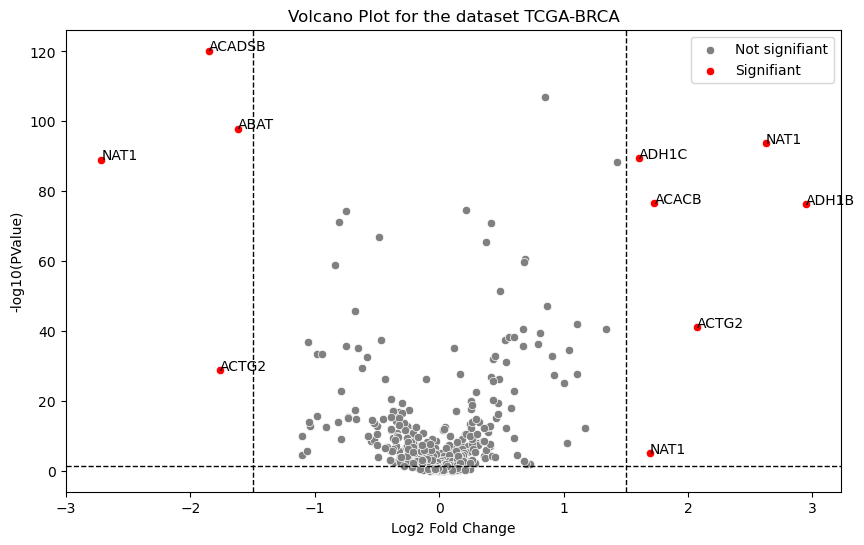

In [13]:
# Je commence par définir un seuil de significativité pour la PValue
seuil = -np.log10(0.05)
pvlog10 = -np.log10(df_TCGA.pvalue.astype(float))
pvlog10 = pvlog10.reset_index(drop=True)
# df["gene"][pvlog10[pvlog10 > 150].index]

# Ensuite je crée le volcano plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_TCGA[(df_TCGA.LOGfc.abs() < 1.5 )]['LOGfc'].values,
                y=pvlog10.iloc[df_TCGA[(df_TCGA.LOGfc.abs() < 1.5 )].index].values,
                # y=pvlog10[pvlog10 < seuil].values,
                color='grey', label='Not signifiant')
sns.scatterplot(x=df_TCGA[(pvlog10 > seuil) & (df_TCGA.LOGfc.abs() > 1.5 )]['LOGfc'].values,
                y=pvlog10.iloc[df_TCGA[(pvlog10 > seuil) & (df_TCGA.LOGfc.abs() > 1.5 )].index].values,
                # y=pvlog10[pvlog10 > seuil].values,
                color='red', label='Signifiant')

# plt.ylim(-50,100)

plt.title('Volcano Plot for the dataset TCGA-BRCA') # plt.title('Volcano Plot pour le jeu de données TCGA-BRCA')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(PValue)')

# Pour ajouter une ligne verticale pour mettre en évidence le seuil de significativité
plt.axvline(x=-1.5, color='black', linestyle='--', linewidth=1)
plt.axvline(x=1.5, color='black', linestyle='--', linewidth=1)
plt.axhline(y=seuil, color='black', linestyle='--', linewidth=1)


# Pour donner le label des points significatifs 
for i,gene in zip(df_TCGA["gene"][(df_TCGA.LOGfc.abs() > 1.5)].index,df_TCGA["gene"][(df_TCGA.LOGfc.abs() > 1.5)].values):
    plt.annotate(gene, (df_TCGA.iloc[i]['LOGfc'], -np.log10(df_TCGA.iloc[i]['pvalue'].astype(float))))

plt.legend()
plt.show()

Toutes les valeurs au dessus de la ligne en pointillé ont un Fold Change qui peut être considéré comme significatif. Au vu du grand nombre de points, il est impossible de préciser le libéllé de chaque point. Cependant, nous affichons les libéllé des points pour lesquels le Fold Change est le plus significatif.

### Création d'une fonction volcano qui choisi un dataset

In [14]:
def volcano(dataset, soustype = None):
    seuil = -np.log10(0.05)
    if soustype == None:
        dff = df[df.dataset == dataset].reset_index()
    else:
        dff = df[(df.dataset == dataset) & (df.type == soustype)].reset_index()
    pvlog10 = -np.log10(dff[dff.dataset == dataset].FDR.astype(float))
    pvlog10 = pvlog10.reset_index(drop=True)

    if len(pvlog10.value_counts()) == 0:
        return "Données non disponible" 

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=dff[(dff.LOGfc.abs() < 1.5)]['LOGfc'].values,
                y=pvlog10.iloc[dff[(dff.LOGfc.abs() < 1.5 )].index].values,
                color='grey', label='Not signifiant')
    sns.scatterplot(x=dff[(pvlog10 > seuil) & (dff.LOGfc.abs() > 1.5)]['LOGfc'].values,
                y=pvlog10.iloc[dff[(pvlog10 > seuil) & (dff.LOGfc.abs() > 1.5)].index].values,
                color='red', label='Signifiant')

    if soustype == None:
        plt.title(f'Volcano Plot for the dataset {dataset}')
    else:
        plt.title(f'Volcano Plot for the dataset {dataset} and subtype {soustype}')
    plt.xlabel('log2(Fold Change)')
    plt.ylabel('-log10(FDR)')

    plt.axvline(x=-1.5, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=1.5, color='black', linestyle='--', linewidth=1)
    plt.axhline(y=seuil, color='black', linestyle='--', linewidth=1)

    # Récupérer les 10 lignes pour lesquelles les pvalues sont les plus elevées
    # pvlog10 = pvlog10.sort_values(ascending=False).iloc[:10]
    # top10 = df[df.dataset == dataset].reset_index(drop=True)
    # top10 = top10.iloc[pvlog10.index[:10]] 

    # for i in range(top10.shape[0]):
    #     plt.annotate(top10.gene.iloc[i], (top10.LOGfc.iloc[i], pvlog10[top10.index[i]]))

    for i,gene in zip(dff["gene"][(dff.LOGfc.abs() > 1.5)].index,dff["gene"][(dff.LOGfc.abs() > 1.5)].values):
        plt.annotate(gene, (dff.iloc[i]['LOGfc'], -np.log10(dff.iloc[i]['pvalue'].astype(float))))

    plt.legend()
    plt.show()

# Exemple d'utilisation de la fonction : 
#   - Paramètre d'entrée : "dataset" qui prend une de ces valeurs : 
#           ['GSE21653', 'Miller-2005', 'Naderi-Caldas-2007', 'E-MTAB-365', 'GSE25066', 'GSE42568', 'TCGA-BRCA', 'Yau-2010']
volcano("Naderi-Caldas-2007")
volcano('Miller-2005')

'Données non disponible'

In [ ]:
volcano("GSE21653")
volcano("E-MTAB-365")
volcano('GSE25066')
volcano('GSE42568')
volcano('TCGA-BRCA')
volcano('Yau-2010')

PS : Pour certains jeu de données, la construction d'un volcano plot est impossible car il faut au moins 2 sous-type du cancer pour pouvoir calculer le Fold Change. Ainsi dans les jeux de données :
- Naderi-Caldas
- Miller

### Remarques interessantes autour des volcano plots

- Le gène MLPH se retouve à la marge dans plusieurs volcano plot, sur les données GSE21653, E-MTAB-365, GSE25066, TCGA-BRCA et Yau-2010 (peut-être données abérrantes ?)
- D'un dataset à l'autre, les ordres de grandeurs sont vraiment différents. Par exemple dans TCGA des valeurs du Log du Fold change peuvent atteindre 100 voir 200 tandis que dans GSE42568, aucun point ne depasse la valeur 20. 

### Volcano plot avec le detail par soustype

In [15]:
def volcano_subtype(dataset, soustype = ['All-tumours', 'Basal-like', 'HER2-enriched', 'Luminal-A', 'Luminal-B']):
    seuil = -np.log10(0.05)
    dff = df[df.dataset == dataset].reset_index()
    pvlog10 = -np.log10(dff.FDR.astype(float))
    pvlog10 = pvlog10.reset_index(drop=True)

    if len(pvlog10.value_counts()) == 0:
        return "Données non disponible" 

    plt.figure(figsize=(10, 6))
    # Pas signifiant 
    sns.scatterplot(x=dff[(dff.LOGfc.abs() < 1.5)]['LOGfc'].values,
                y=pvlog10.iloc[dff[(dff.LOGfc.abs() < 1.5)].index].values,
                color='grey', label='Not signifiant',
                style = dff[dff.LOGfc.abs() < 1.5].type, style_order = soustype)
    # Signifiant
    sns.scatterplot(x=dff[(pvlog10 > seuil) & (dff.LOGfc.abs() > 1.5)]['LOGfc'].values, color='red',
                    y=pvlog10.iloc[dff[(pvlog10 > seuil) & (dff.LOGfc.abs() > 1.5)].index].values,
                    style = dff[(pvlog10 > seuil) & (dff.LOGfc.abs() > 1.5)].type, style_order = soustype)

    plt.title(f'Volcano Plot for the dataset {dataset}')
    plt.xlabel('log2(Fold Change)')
    plt.ylabel('-log10(FDR)')

    plt.axvline(x=-1.5, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=1.5, color='black', linestyle='--', linewidth=1)
    plt.axhline(y=seuil, color='black', linestyle='--', linewidth=1)

    for i,gene in zip(dff["gene"][(dff.LOGfc.abs() > 1.5)].index,dff["gene"][(dff.LOGfc.abs() > 1.5)].values):
        plt.annotate(gene, (dff.iloc[i]['LOGfc'], -np.log10(dff.iloc[i]['FDR'].astype(float))))

    # Pour garder que les 5 premiers éléments de la légende
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(handles) > 5:
        plt.legend(handles[1:6], labels[1:6], loc='best')
    else:
        plt.legend(handles, labels, loc='best')
        
    plt.show()

# Exemple d'utilisation de la fonction : 
#   - Paramètre d'entrée : "dataset" qui prend une de ces valeurs : 
#           ['GSE21653', 'Miller-2005', 'Naderi-Caldas-2007', 'E-MTAB-365', 'GSE25066', 'GSE42568', 'TCGA-BRCA', 'Yau-2010']
volcano_subtype("Naderi-Caldas-2007")
volcano_subtype('Miller-2005')

'Données non disponible'

In [ ]:
volcano_subtype("GSE21653")
volcano_subtype("E-MTAB-365")
volcano_subtype('GSE25066')
volcano_subtype('GSE42568')
volcano_subtype('TCGA-BRCA')
volcano_subtype('Yau-2010')

#### Remarques 
Pour ces deuxièmes types de volcano plot, il y a quelques remarques intéressantes à faire : 
- Les points les plus significatifs sont dans chaque datasets pour le basal-like contre le reste
- On retrouve aussi beaucoup de Luminal-A
- Les autres types semblent se fondre dans la masse dans tous les datasets

### Réaliser une analyse de survie sur python 

On commence avec un premier exemple dans le jeu de données EMTAB pour le gène EZH2

In [16]:
expression = E_MTAB_365[E_MTAB_365.gene_symbol == "EZH2"]
expression.dropna(axis=1)

,id_gene,gene_symbol,CIT_DSOA_001,CIT_DSOA_002,CIT_DSOA_003,CIT_DSOA_004,CIT_DSOA_005,CIT_DSOA_006,CIT_DSOA_007,CIT_DSOA_008,...,CIT_DSOA_528,CIT_DSOA_529,CIT_DSOA_530,CIT_DSOA_531,CIT_DSOA_532,CIT_DSOA_533,CIT_DSOA_534,CIT_DSOA_535,CIT_DSOA_536,CIT_DSOA_537
1513,2146,EZH2,8.426623,6.877132,7.572731,5.29231,6.226845,6.886607,7.484511,6.418675,...,6.682147,6.449759,5.907661,6.008499,6.067995,6.238021,6.1007,6.347094,5.382535,5.934367


In [18]:
# Recuperons maintenant les données de survie 
survie = E_MTAB_365_EG[["id_sample","os_months","os_censor","dfs_months","dfs_censor"]]
survie = survie.dropna()

In [19]:
# Nous conservons uniquement les échantillons pour lesquelles nous avons une expression de gènes (pas de NA)
expression = expression[E_MTAB_365_EG[["id_sample","os_months","os_censor","dfs_months","dfs_censor"]]['id_sample'].values].dropna(axis=1)

In [20]:
# On passe la ligne de données en une colonne et on la renomme "value"
expression = expression[survie.id_sample].T
expression.columns = ["value"]

In [21]:
survie = pd.concat([survie.reset_index(drop=True),expression.reset_index(drop=True)],axis=1)

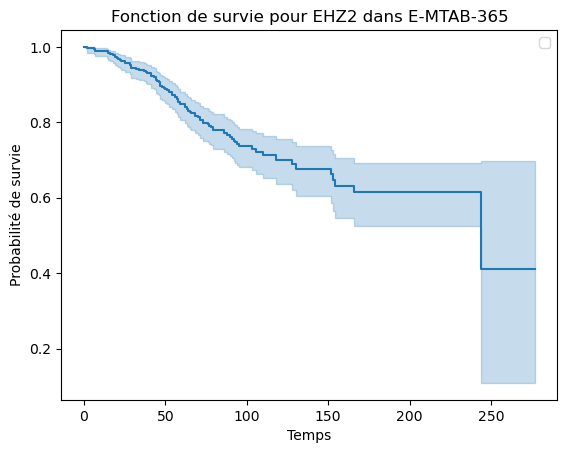

In [22]:
# Initialiser le modèle Kaplan-Meier
kmf = KaplanMeierFitter()

# Ajuster le modèle aux données de survie
kmf.fit(durations=survie['os_months'], event_observed=survie['os_censor'])

# Afficher la fonction de survie
kmf.plot_survival_function()
plt.title('Fonction de survie pour EHZ2 dans E-MTAB-365')
plt.xlabel('Temps')
plt.ylabel('Probabilité de survie')
plt.legend("")
plt.show()

Ci-dessus, nous avons un premier exemple d'analyse de survie pour le gène EHZ2 dans le jeu de données E-MTAB-365

### Courbe Low et High dans la courbe de survie 

In [40]:
mediane = np.percentile(survie["value"],50)
survie[survie["value"] > mediane]["os_months"]

0       78.0
1       62.0
2      110.0
5      104.0
6       75.0
       ...  
406     28.0
411     97.0
413    166.0
417    186.0
418    104.0
Name: os_months, Length: 214, dtype: float64

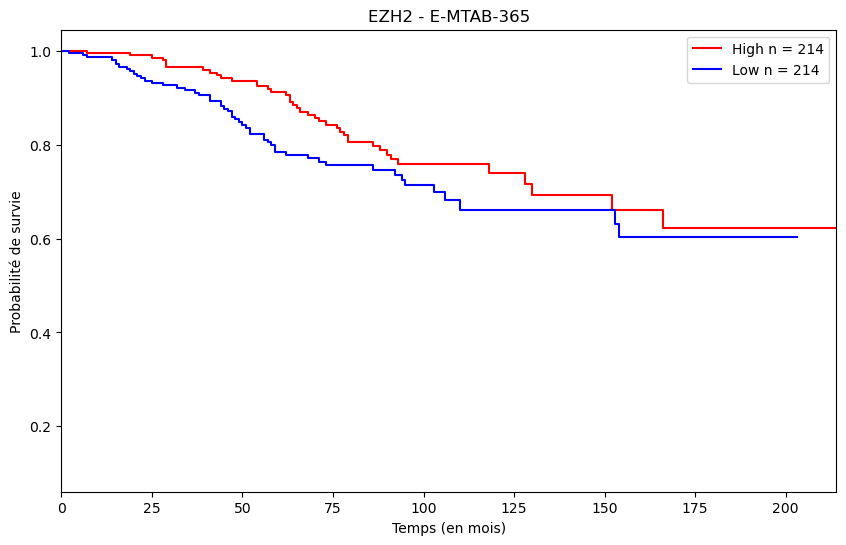

In [23]:
# Définir le critère pour séparer les 2 groupes : 
mediane = np.percentile(survie["value"],50)

# Créer deux instances distinctes de KaplanMeierFitter
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

# Definition des 2 groupes (Low et High)
high = survie[survie["value"] > mediane]
low = survie[survie["value"] < mediane]

# Ajuster les modèles aux données de survie respectives
kmf1.fit(durations=high["os_months"], event_observed=high['os_censor'])
kmf2.fit(durations=low["os_months"], event_observed=low['os_censor'])

# Tracer les courbes de survie
plt.figure(figsize=(10, 6))
kmf2.plot_survival_function(label=f'High n = {high.shape[0]}',color='red',ci_alpha=0)
kmf1.plot_survival_function(label=f'Low n = {low.shape[0]}',color='blue',ci_alpha=0)


plt.xlim(0,min(len(low),len(high)))

# Ajouter des titres et légendes
plt.title(f'EZH2 - E-MTAB-365') 
# plt.title(f'EZH2 - E-MTAB-365\ncox p-value : {res['p'].values}\nlogrank p-value : {res_logr.summary['p']}')
plt.xlabel('Temps (en mois)') # plt.xlabel('Temps')
plt.ylabel('Probabilité de survie') # plt.ylabel('Probabilité de survie')
plt.legend()

# Afficher le graphique
plt.show()


#### Généraliser avec une fonction qui prend en entrée un gène et un jeu de données

C:\Users\zergu\AppData\Local\Temp\ipykernel_4804\565863982.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data2['id_sample'].isin(cancer[cancer.Dataset == dataset.replace("_","-")][cancer[soustype] == 1]['Sample'])][
C:\Users\zergu\AppData\Local\Temp\ipykernel_4804\565863982.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data2['id_sample'].isin(cancer[cancer.Dataset == dataset.replace("_","-")][cancer[soustype] == 1]['Sample'])][


(<module 'matplotlib.pyplot' from 'c:\\Users\\zergu\\.conda\\envs\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>,
         id_sample  os_months  os_censor  dfs_months  dfs_censor     value
 0    CIT_DSOA_001       78.0        0.0        78.0         0.0  8.426623
 1    CIT_DSOA_002       62.0        0.0        62.0         0.0  6.877132
 2    CIT_DSOA_003      110.0        1.0        82.0         1.0  7.572731
 3    CIT_DSOA_004       98.0        0.0        98.0         0.0  5.292310
 4    CIT_DSOA_005       85.0        0.0        76.0         1.0  6.226845
 ..            ...        ...        ...         ...         ...       ...
 423  CIT_DSOA_533      260.0        0.0       260.0         0.0  6.238021
 424  CIT_DSOA_534      128.0        1.0       128.0         1.0  6.100700
 425  CIT_DSOA_535      147.0        0.0       147.0         0.0  6.347094
 426  CIT_DSOA_536      126.0        0.0       126.0         0.0  5.382535
 427  CIT_DSOA_537      214.0        0.0       214.0     

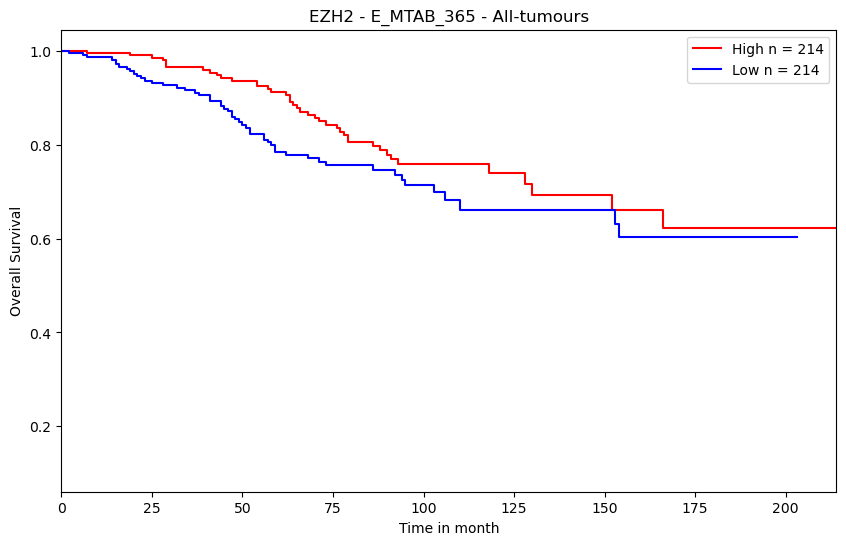

In [24]:
def get_survie(dataset,dataset2, gene, soustype, typesurvie,afficher_graphique):
    data = globals()[dataset]
    data2 = globals()[dataset2]
    expression = data[data.gene_symbol == gene]
    expression.dropna(axis=1)
    survie = data2[
        data2['id_sample'].isin(cancer[cancer.Dataset == dataset.replace("_","-")][cancer[soustype] == 1]['Sample'])][
            ["id_sample","os_months","os_censor","dfs_months","dfs_censor"]]
    # Ce if permet d'arrêter la fonction si les données sont manquantes
    if(typesurvie == "OS"):
        x = "os_months" 
        y = "os_censor"
        if(survie[x].value_counts().shape[0] == 0 or survie[y].value_counts().shape[0] == 0):
            return "Les données de survie ne sont pas disponible"
    else:
        x = "dfs_months"
        y = "dfs_censor"
        if(survie[x].value_counts().shape[0] == 0 or survie[y].value_counts().shape[0] == 0):
            return "Les données de survie ne sont pas disponible"
    survie = survie.dropna(axis = 1, how="all")
    survie = survie.dropna(axis = 0, how="any")
    expression = expression[data2[["id_sample","os_months","os_censor","dfs_months","dfs_censor"]]['id_sample'].values].dropna(axis=1)
    expression = expression[survie.id_sample].T
    expression.columns = ["value"]
    survie = pd.concat([survie.reset_index(drop=True),expression.reset_index(drop=True)],axis=1)
    mediane = np.percentile(survie["value"],50)

    if afficher_graphique:
        kmf1 = KaplanMeierFitter()
        kmf2 = KaplanMeierFitter()
        high = survie[survie["value"] > mediane]
        low = survie[survie["value"] < mediane]
        kmf1.fit(durations=high[x], event_observed=high[y])
        kmf2.fit(durations=low[x], event_observed=low[y])
        plt.figure(figsize=(10, 6))
        kmf2.plot_survival_function(label=f'High n = {high.shape[0]}',color='red',ci_alpha=0)
        kmf1.plot_survival_function(label=f'Low n = {low.shape[0]}',color='blue',ci_alpha=0)
        plt.xlim(0,min(len(low),len(high)))
        plt.title(f'{gene} - {dataset} - {soustype}') 
        # plt.title(f'EZH2 - E-MTAB-365\ncox p-value : {res['p'].values}\nlogrank p-value : {res_logr.summary['p']}')
        plt.xlabel('Time in month')
        if(typesurvie == "OS"):
            plt.ylabel('Overall Survival')
        else: 
            plt.ylabel('Disease Free Survival')
        plt.legend()
    
    return plt if afficher_graphique else None, survie


# Voici un exemple
# On commence par renseigner la chaîne de caractère associée au dataframe qui donne les données d'expressions 
# puis celle du dataframe qui donne les annotations biocliniques
get_survie("GSE21653","GSE21653_EG","EZH2","All-tumours","OS",False)
get_survie("E_MTAB_365","E_MTAB_365_EG","EZH2","All-tumours","OS", True)

#### Le test du LogRank

Le test du Log Rank est un test qui permet de comparer 2 populations de patients pour voir si elles ont la même probabilité de survie. Pour le modèle de Cox, on estime l’impact de la valeur numérique du niveau d’expression du gène sur 
la probabilité de survie. Est-ce  que  l’augmentation  du  niveau  d’expression  est  associée  à 
l’augmentation du risque de décès ? On calcule la p-valeur associée et le hasard ratio du modèle.

In [25]:
a = get_survie("E_MTAB_365","E_MTAB_365_EG","EZH2","All-tumours","OS",False)[1]
mediane = np.percentile(a["value"],50)
high = a[a["value"] > mediane]
low = a[a["value"] < mediane]


kmf_A = KaplanMeierFitter()
kmf_B = KaplanMeierFitter()
kmf_A.fit(durations=low['os_months'], event_observed=low['os_censor'], label='Low')
kmf_B.fit(durations=high['os_months'], event_observed=high['os_censor'], label='High')
res_logr = logrank_test(low['os_months'], high['os_months'], event_observed_A=low['os_censor'], event_observed_B=high['os_censor'])
print(res_logr.summary)

C:\Users\zergu\AppData\Local\Temp\ipykernel_4804\565863982.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data2['id_sample'].isin(cancer[cancer.Dataset == dataset.replace("_","-")][cancer[soustype] == 1]['Sample'])][


   test_statistic         p  -log2(p)
0        2.643677  0.103963  3.265862


Une fonction pour généraliser le calcul du LogRank

In [26]:
def logRank(dataset,dataset2,gene,soustype, typesurvie):
    a = get_survie(dataset,dataset2,gene,soustype, typesurvie,False)[1]
    if not isinstance(a, pd.DataFrame):
        return "Les données de survie ne sont pas disponible"
    if(sum(a.value) == 0):
        return "Les expressions data valent tous 0"
    if(typesurvie == "OS"):
        x = "os_months" 
        y = "os_censor"
    else:
        x = "dfs_months"
        y = "dfs_censor"
    mediane = np.percentile(a["value"],50)
    if mediane == 0:
        a_sort = a.sort_values(by='value', ascending=False)
        high = a_sort.head(len(a_sort) // 2)
        low = a_sort.tail(len(a_sort) // 2)
    else:
        high = a[a["value"] > mediane]
        low = a[a["value"] <= mediane]
    kmf_A = KaplanMeierFitter()
    kmf_B = KaplanMeierFitter()
    kmf_A.fit(durations=low[x], event_observed=low[y], label='Low')
    kmf_B.fit(durations=high[x], event_observed=high[y], label='High')
    res_logr = logrank_test(low[x], high[x], event_observed_A=low[y], event_observed_B=high[y])
    return np.round(res_logr.summary["p"].values.item(),2)

# Test de la fonction 
logRank("E_MTAB_365","E_MTAB_365_EG","EZH2","All-tumours","OS")

C:\Users\zergu\AppData\Local\Temp\ipykernel_4804\565863982.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data2['id_sample'].isin(cancer[cancer.Dataset == dataset.replace("_","-")][cancer[soustype] == 1]['Sample'])][


0.1

### Le modèle de Cox

Il peut vulgairement être vu comme une régression linéaire adapté à des données de survie. On va donc regarder si le niveau d'expression d'une gène donné impact la probabilité de survie. 

In [27]:
def Cox(dataset,dataset2,gene,soustype, typesurvie):
    a = get_survie(dataset,dataset2,gene,soustype, typesurvie,False)[1]
    if not isinstance(a, pd.DataFrame):
        return "Les données de survie ne sont pas disponible"
    if(sum(a.value) == 0):
        return "Les expressions data valent tous 0"
    if(typesurvie == "OS"):
        x = "os_months" 
        y = "os_censor"
    else:
        x = "dfs_months"
        y = "dfs_censor"
    mediane = np.percentile(a["value"],50)
    if mediane == 0:
        a_sort = a.sort_values(by='value', ascending=False)
        high = a_sort.head(len(a_sort) // 2)
        low = a_sort.tail(len(a_sort) // 2)
    else:
        high = a[a["value"] > mediane]
        low = a[a["value"] <= mediane]
    low['group'] = ["Low"]*low.shape[0]
    high['group'] = ["High"]*high.shape[0]
    data = pd.concat([low,high])
    if(data[data.group == "High"].shape[0] < 0.05* data.shape[0]):
        return "Trop peu de High", "Trop peu de High"
        # return NaN, NaN
    coxph = CoxPHFitter()
    coxph.fit(data, duration_col=x, event_col=y, formula='group')
    res = coxph.summary
    return np.round(res['p'].values.item(), 2), np.round(res['coef'].values.item(), 1)


# Test de la fonction 
Cox("E_MTAB_365","E_MTAB_365_EG","EZH2","All-tumours","OS")

C:\Users\zergu\AppData\Local\Temp\ipykernel_4804\565863982.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data2['id_sample'].isin(cancer[cancer.Dataset == dataset.replace("_","-")][cancer[soustype] == 1]['Sample'])][
C:\Users\zergu\AppData\Local\Temp\ipykernel_4804\341918428.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low['group'] = ["Low"]*low.shape[0]
C:\Users\zergu\AppData\Local\Temp\ipykernel_4804\341918428.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(0.11, -0.3)

Dans la sortie précédente, nous obtenons directement le hazard ratio en même temps que la p-valeur du modèle de Cox !

### Ajout des tests sur le graphique de l'analyse de survie 

C:\Users\zergu\AppData\Local\Temp\ipykernel_4804\565863982.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data2['id_sample'].isin(cancer[cancer.Dataset == dataset.replace("_","-")][cancer[soustype] == 1]['Sample'])][
C:\Users\zergu\AppData\Local\Temp\ipykernel_4804\565863982.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data2['id_sample'].isin(cancer[cancer.Dataset == dataset.replace("_","-")][cancer[soustype] == 1]['Sample'])][
C:\Users\zergu\AppData\Local\Temp\ipykernel_4804\565863982.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data2['id_sample'].isin(cancer[cancer.Dataset == dataset.replace("_","-")][cancer[soustype] == 1]['Sample'])][
C:\Users\zergu\AppData\Local\Temp\ipykernel_4804\341918428.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

<module 'matplotlib.pyplot' from 'c:\\Users\\zergu\\.conda\\envs\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

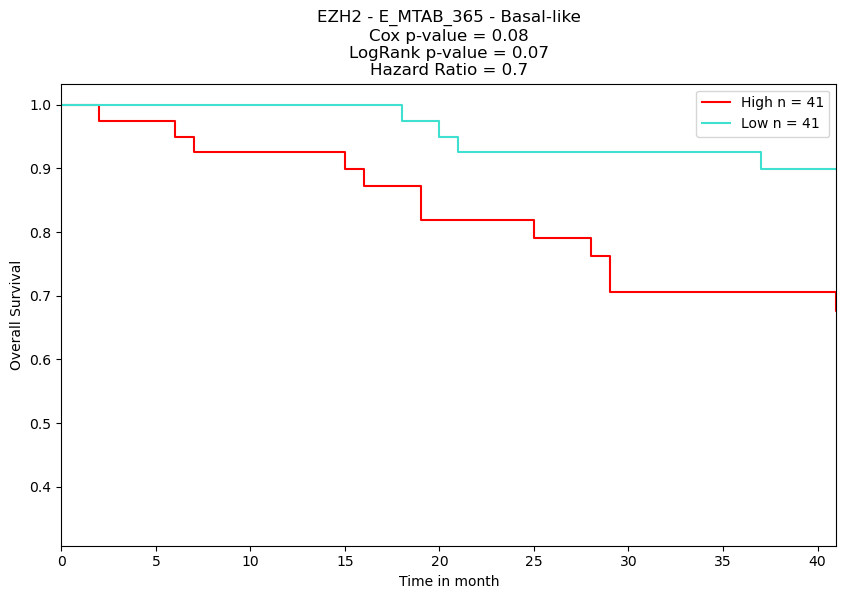

In [28]:
# Pour afficher les graphiques un par un
def get_survie_final(dataset,dataset2, gene, soustype, typesurvie):
    survie = get_survie(dataset, dataset2, gene, soustype, typesurvie,False)[1]
    rank = logRank(dataset, dataset2, gene, soustype, typesurvie)
    cox, HR = Cox(dataset, dataset2, gene, soustype, typesurvie)
    if(typesurvie == "OS"):
        x = "os_months" 
        y = "os_censor"
    else:
        x = "dfs_months"
        y = "dfs_censor"
    mediane = np.percentile(survie["value"],50)
    kmf1 = KaplanMeierFitter()
    kmf2 = KaplanMeierFitter()
    # On gère le cas où la médiane est égale à 0
    if mediane == 0:
        survie_sort = survie.sort_values(by='value', ascending=False)
        high = survie_sort.head(len(survie_sort) // 2)
        low = survie_sort.tail(len(survie_sort) // 2)
    else:
        high = survie[survie["value"] > mediane]
        low = survie[survie["value"] <= mediane]
    n = low.shape[0] + high.shape[0]
    kmf1.fit(durations=high[x], event_observed=high[y])
    kmf2.fit(durations=low[x], event_observed=low[y])
    plt.figure(figsize=(10, 6))
    kmf2.plot_survival_function(label=f'High n = {high.shape[0]}',color='red',ci_alpha=0)
    kmf1.plot_survival_function(label=f'Low n = {low.shape[0]}',color='#40E0D0',ci_alpha=0)
    plt.xlim(0,min(len(low),len(high)))
    plt.title(f'{gene} - {dataset} - {soustype}\nCox p-value = {cox}\nLogRank p-value = {rank}\nHazard Ratio = {HR}') 
    # plt.title(f'EZH2 - E-MTAB-365\ncox p-value : {res['p'].values}\nlogrank p-value : {res_logr.summary['p']}')
    plt.xlabel('Time in month')
    if(typesurvie == "OS"):
        plt.ylabel('Overall Survival')
    else: 
        plt.ylabel('Disease Free Survival')
    plt.legend()
    # On retourne à la fois le graphique et le tableau des données de survie
    return plt,rank,cox,HR,n


# Voici un exemple
# On commence par renseigner la chaîne de caractère associée au dataframe qui donne les données d'expressions 
# puis celle du dataframe qui donne les annotations biocliniques
# get_survie_final("GSE21653","GSE21653_EG","EZH2","All-tumours","OS")
get_survie_final("E_MTAB_365","E_MTAB_365_EG","EZH2","Basal-like","OS")[0]

In [29]:
# Cette deuxième version du get_survie_final permet d'afficher plusieurs plots en même temps
def get_survie_final_plots(ax, dataset, dataset2, gene, soustype, typesurvie):
    survie = get_survie(dataset, dataset2, gene, soustype, typesurvie,False)[1]
    rank = logRank(dataset, dataset2, gene, soustype, typesurvie)
    cox, HR = Cox(dataset, dataset2, gene, soustype, typesurvie)
    if(typesurvie == "OS"):
        x = "os_months" 
        y = "os_censor"
    else:
        x = "dfs_months"
        y = "dfs_censor"
    mediane = np.percentile(survie["value"],50)
    kmf1 = KaplanMeierFitter()
    kmf2 = KaplanMeierFitter()
    # On gère le cas où la médiane est égale à 0
    if mediane == 0:
        survie_sort = survie.sort_values(by='value', ascending=False)
        high = survie_sort.head(len(survie_sort) // 2)
        low = survie_sort.tail(len(survie_sort) // 2)
    else:
        high = survie[survie["value"] > mediane]
        low = survie[survie["value"] <= mediane]
    n = low.shape[0] + high.shape[0]
    if n < 100:
        return rank, cox, HR, n
    kmf1.fit(durations=high[x], event_observed=high[y])
    kmf2.fit(durations=low[x], event_observed=low[y])
    kmf2.plot_survival_function(ax=ax, label=f'High n = {high.shape[0]}', color='red', ci_alpha=0)
    kmf1.plot_survival_function(ax=ax, label=f'Low n = {low.shape[0]}', color='#40E0D0', ci_alpha=0)
    ax.set_xlim(0, min(len(low), len(high)))
    ax.set_title(f'{gene} - {dataset} - {soustype}\nCox p-value = {cox}\nLogRank p-value = {rank}\nHazard Ratio = {HR}')
    cox_sci = "{:.2e}".format(cox)
    rank_sci = "{:.2e}".format(rank)
    ax.set_title(f'{gene} - {dataset} - {soustype}\nCox p-value = {cox_sci}\nLogRank p-value = {rank_sci}\nHazard Ratio = {HR}')
    ax.set_xlabel('Time in month')
    if(typesurvie == "OS"):
        ax.set_ylabel('Overall Survival')
    else:
        ax.set_ylabel('Disease Free Survival')
    ax.legend()
    return rank, cox, HR, n

### Le but va être de conserver les gènes pour un dataset donné et un sous type donné qui impactent le plus la survie 

In [ ]:
# Nous allons conserver les N plus impactent la survie en se basant sur la pvaleur du test du Logrank et le hazard ratio
# On initialise une liste de tous les dataframe
dataset = ["GSE21653", "Miller", "Naderi_Caldas", "E_MTAB_365", "GSE25066", "GSE42568", "TCGA_BRCA", "Yau"]
soustypes = ["All-tumours", "Luminal-A", "Luminal-B", "HER2-enriched", "Basal-like"]
typessurvie = ["OS", "DFS"]

# On initialise un dataframe vide 
dataf = pd.DataFrame(columns = ['dataset','gene', 'soustype', 'typesurvie' ,'pval_logRank', 'pval_Cox' 'HR'])

for d in dataset:
    for g in globals()[d].gene_symbol.unique():
        for st in soustypes:
            for ts in typessurvie:
                rank = logRank(d,d+"_EG",g,st,ts)
                cox = Cox(d,d+"_EG",g,st,ts)[0]
                ratio = Cox(d,d+"_EG",g,st,ts)[1]
                nvl = {'dataset': d, 'gene': g, 'soustype': st, 'typesurvie': ts, 'pval_logRank':rank, 'pval_Cox':cox,'HR' : ratio}
                dataf = dataf.append(nvl, ignore_index=True)

j'en suis a la, ne pas oublier de passer au FDR pour logrank et cox

In [30]:
df = pd.read_pickle("Brouillons/BrouillonPython/all_survie_DV")

Ajout du nombre d'individus total dans le tableau all_survie

In [ ]:
n = []
for i in range(all_survie.shape[0]):
    row = all_survie.iloc[i]
    nb = get_survie(row['dataset'], row['dataset'] + "_EG", row['gene'], row['soustype'], row['typesurvie'],False)
    if isinstance(nb, str):
        n.append(0)
    else:
        n.append(get_survie(row['dataset'], row['dataset'] + "_EG", row['gene'], row['soustype'], row['typesurvie'],False)[1].shape[0])

In [31]:
all_survie = pd.read_pickle("data/all_res_survie.pkl")
all_survie['pval_logRank'] = pd.to_numeric(all_survie['pval_logRank'], errors='coerce')
all_survie['HR'] = pd.to_numeric(all_survie['HR'], errors='coerce')

In [32]:
all_survie = all_survie[all_survie.n > 0].reset_index(drop=True)

On calcule les FDR (avec la méthode de Bonferroni) pour les pvalues de Logrank et Cox

In [33]:
all_survie['FDR_logrank'] = pd.NA
grouped = all_survie.groupby(['dataset', 'gene'])
for (dataset, gene), group in grouped:
    original_pvals = group['pval_logRank'].values
    adj_pvals = multipletests(original_pvals, alpha=0.05, method='fdr_bh')[1]
    all_survie.loc[group.index, 'FDR_logrank'] = adj_pvals

all_survie['FDR_Cox'] = pd.NA
grouped = all_survie.groupby(['dataset', 'gene'])
for (dataset, gene), group in grouped:
    original_pvals = group['pval_Cox'].values
    adj_pvals = multipletests(original_pvals, alpha=0.05, method='fdr_bh')[1]
    all_survie.loc[group.index, 'FDR_Cox'] = adj_pvals

In [34]:
# Par exemple, je veux que les HER2-enriched en OS
# Je récupère les 10 HR les plus élevée
all_survie[(all_survie.soustype == "HER2-enriched") & (all_survie.typesurvie == "DFS")].sort_values(by = ["HR","n"], ascending=False)[0:10]

,dataset,gene,soustype,typesurvie,pval_logRank,HR,n,FDR_logrank
783,GSE21653,EHMT2,HER2-enriched,DFS,0.00,18.6,22,0.0
10158,GSE25066,FYCO1,HER2-enriched,DFS,0.00,18.3,37,0.0
10153,GSE25066,DCAF10,HER2-enriched,DFS,0.01,18.2,37,0.025
2363,GSE21653,PWWP2A,HER2-enriched,DFS,0.01,18.2,22,0.025
9648,GSE25066,UTP18,HER2-enriched,DFS,0.02,18.1,37,0.1
2678,GSE21653,SHPRH,HER2-enriched,DFS,0.02,17.4,22,0.1
10373,GSE25066,TBC1D31,HER2-enriched,DFS,0.02,2.2,37,0.05
958,GSE21653,SETD1B,HER2-enriched,DFS,0.02,2.2,22,0.1
1018,GSE21653,RRP8,HER2-enriched,DFS,0.01,2.2,22,0.05
2093,GSE21653,ASXL3,HER2-enriched,DFS,0.02,2.2,22,0.1


PS : Nous observons que pour ces 10 premiers HR obtenus, le nombre d'individus est très faible ! 
Nous verrons par la suite comment gérer cela 

Afficher les 10 Hazard ratio les plus élevée pour les HER2-enriched en Overall Survival

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
axes_flat = axes.flatten()

myDF = all_survie[(all_survie.soustype == "HER2-enriched") & (all_survie.typesurvie == "DFS")].sort_values(by = "HR", ascending=False)[0:10]

for i, ax in enumerate(axes_flat):
    if i < len(myDF):
        row = myDF.iloc[i]
        get_survie_final_plots(ax, row['dataset'], row['dataset'] + "_EG", row['gene'], row['soustype'], row['typesurvie'])
    else:
        ax.set_visible(False) 

plt.tight_layout()

fig.suptitle('Les survies les plus impactées pour le sous type HER2-enriched en Overall Survival', fontsize=20)
plt.subplots_adjust(top=0.85)

plt.show()

PS : Dans la figure ci-dessus, aucune analyse de survie ne s'affiche car la condition pour réaliser une analyse de survie est que le nombre total d'observations soit de 100 au minimum

In [36]:
# Fonction qui généralise cela (en ne conservant que les échantillons qui contiennent au moins 100 individus ())
def get_best_survie(subtype, typesurvie):
    myDF = all_survie[(all_survie.soustype == subtype) & (all_survie.typesurvie == typesurvie) & (all_survie.n >= 100)].sort_values(by = "HR", ascending=False)[0:10]
    if myDF.shape[0] == 0:
        return "Les analyses de survie ne peuvent pas être réalisées car les données ne sont pas disponible ou les effectifs sont trop faibles"
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
    axes_flat = axes.flatten()

    for i, ax in enumerate(axes_flat):
        if i < len(myDF):
            row = myDF.iloc[i]
            get_survie_final_plots(ax, row['dataset'], row['dataset'] + "_EG", row['gene'], row['soustype'], row['typesurvie'])
        else:
            ax.set_visible(False)

    plt.tight_layout()
    if(typesurvie == "OS"):
        ts = "Overall Survival"
    else:
        ts = "Disease Free Survival"
    fig.suptitle(f'Les survies les plus impactées pour le sous type {subtype} en {ts}', fontsize=20)
    plt.subplots_adjust(top=0.85)
    plt.show()

In [298]:
get_best_survie("HER2-enriched", "DFS")

'Les analyses de survie ne peuvent pas être réalisées car les données ne sont pas disponible ou les effectifs sont trop faibles'

[codecarbon INFO @ 10:45:18] Energy consumed for RAM : 0.059181 kWh. RAM Power : 2.7474818229675293 W
[codecarbon INFO @ 10:45:18] Energy consumed for all CPUs : 0.915629 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:45:18] 0.974810 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:45:22] Energy consumed for RAM : 0.063287 kWh. RAM Power : 2.7474818229675293 W
[codecarbon INFO @ 10:45:22] Energy consumed for all CPUs : 0.979185 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:45:22] 1.042472 kWh of electricity used since the beginning.


Une amélioration de la première version

In [37]:
def get_best_survie2(subtype, typesurvie):
    # Filtrer et trier les données selon le sous-type et le type de survie, en prenant les 100 premières entrées avec le HR le plus élevé
    # myDF = all_survie[(all_survie.soustype == subtype) &
    #                    (all_survie.typesurvie == typesurvie) &
    #                      (all_survie.n >= 100) &
    #                      (all_survie['FDR_logrank'] <= 0.1 | all_survie['FDR_Cox'] <= 0.1)].sort_values(by="HR", ascending=False)[:1000]
    myDF = df[(df.soustype == subtype) &
                       (df.typesurvie == typesurvie) &
                         (df.n >= 100) &
                          (df['FDR_logrank'] <= 0.1 | df['FDR_Cox'] <= 0.1)].sort_values(by="HR", ascending=False)[:1000]
    if myDF.shape[0] == 0:
        return "Les analyses de survie ne peuvent pas être réalisées car les données ne sont pas disponible ou les effectifs sont trop faibles"
    
    # Déterminer le nombre de graphiques à afficher (max 10 pour cet exemple)
    nrows, ncols = 2, 5
    n_plots = min(len(myDF), nrows * ncols)
    
    # Créer une figure et un ensemble d'axes pour les sous-graphiques
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))
    axes_flat = axes.flatten()

    # Remplir chaque axe avec un graphique de survie
    j = 0
    for i in range(myDF.shape[0]):
        row = myDF.iloc[i]
        while get_survie_final_plots(axes_flat[i], row['dataset'], row['dataset'] + "_EG", row['gene'], row['soustype'], row['typesurvie'])[3] < 100:
            j = j + 1 
            row = myDF.iloc[j]
        get_survie_final_plots(axes_flat[i], row['dataset'], row['dataset'] + "_EG", row['gene'], row['soustype'], row['typesurvie'])
    
    # Masquer les axes inutilisés si myDF contient moins de 10 éléments
    for ax in axes_flat[n_plots:]:
        ax.set_visible(False)

    plt.tight_layout()
    
    # Définir le titre de la figure en fonction du type de survie
    ts = "Overall Survival" if typesurvie == "OS" else "Disease Free Survival"
    fig.suptitle(f'Les survies les plus impactées pour le sous type {subtype} en {ts}', fontsize=20)
    
    # Ajuster l'espace pour le titre de la figure
    plt.subplots_adjust(top=0.85)
    
    plt.show()

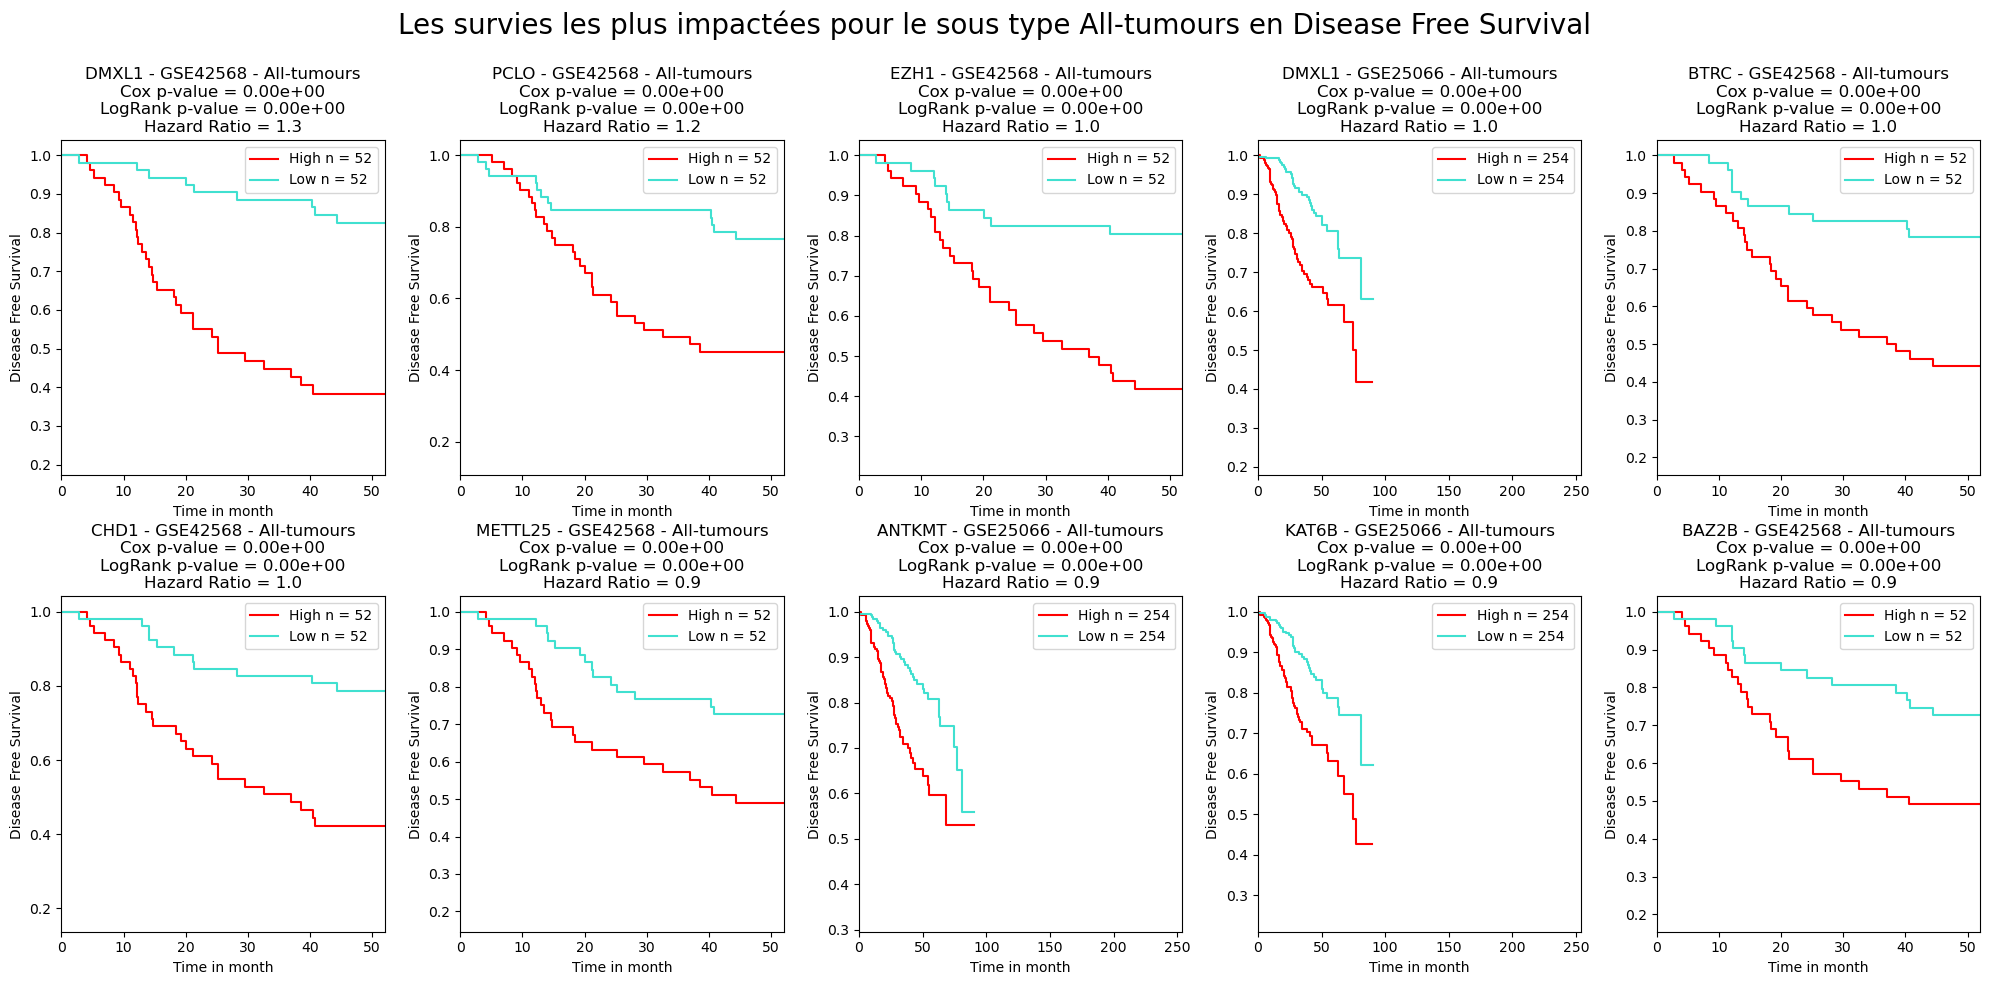

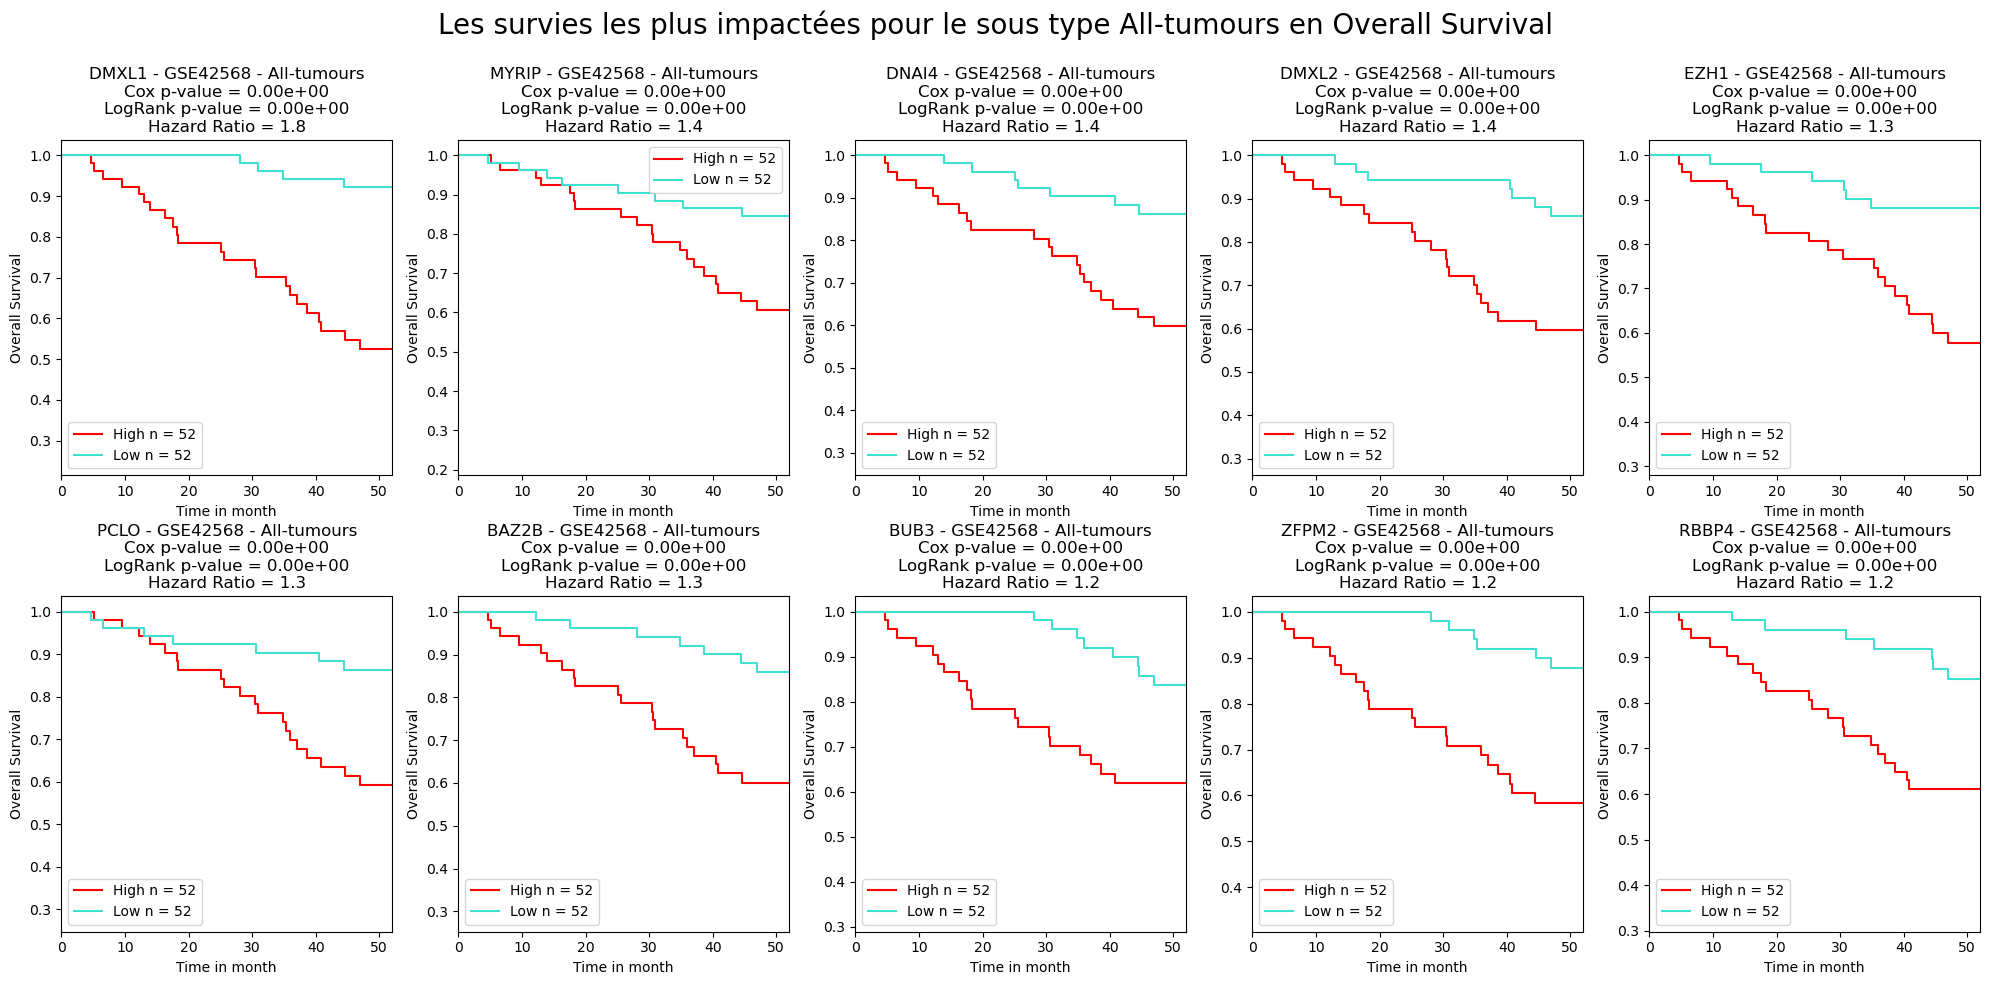

In [225]:
get_best_survie("All-tumours", "DFS")
get_best_survie("All-tumours", "OS")

In [197]:
get_best_survie("HER2-enriched", "DFS")
get_best_survie("HER2-enriched", "OS")

'Les analyses de survie ne peuvent pas être réalisées car les données ne sont pas disponible ou les effectifs sont trop faibles'

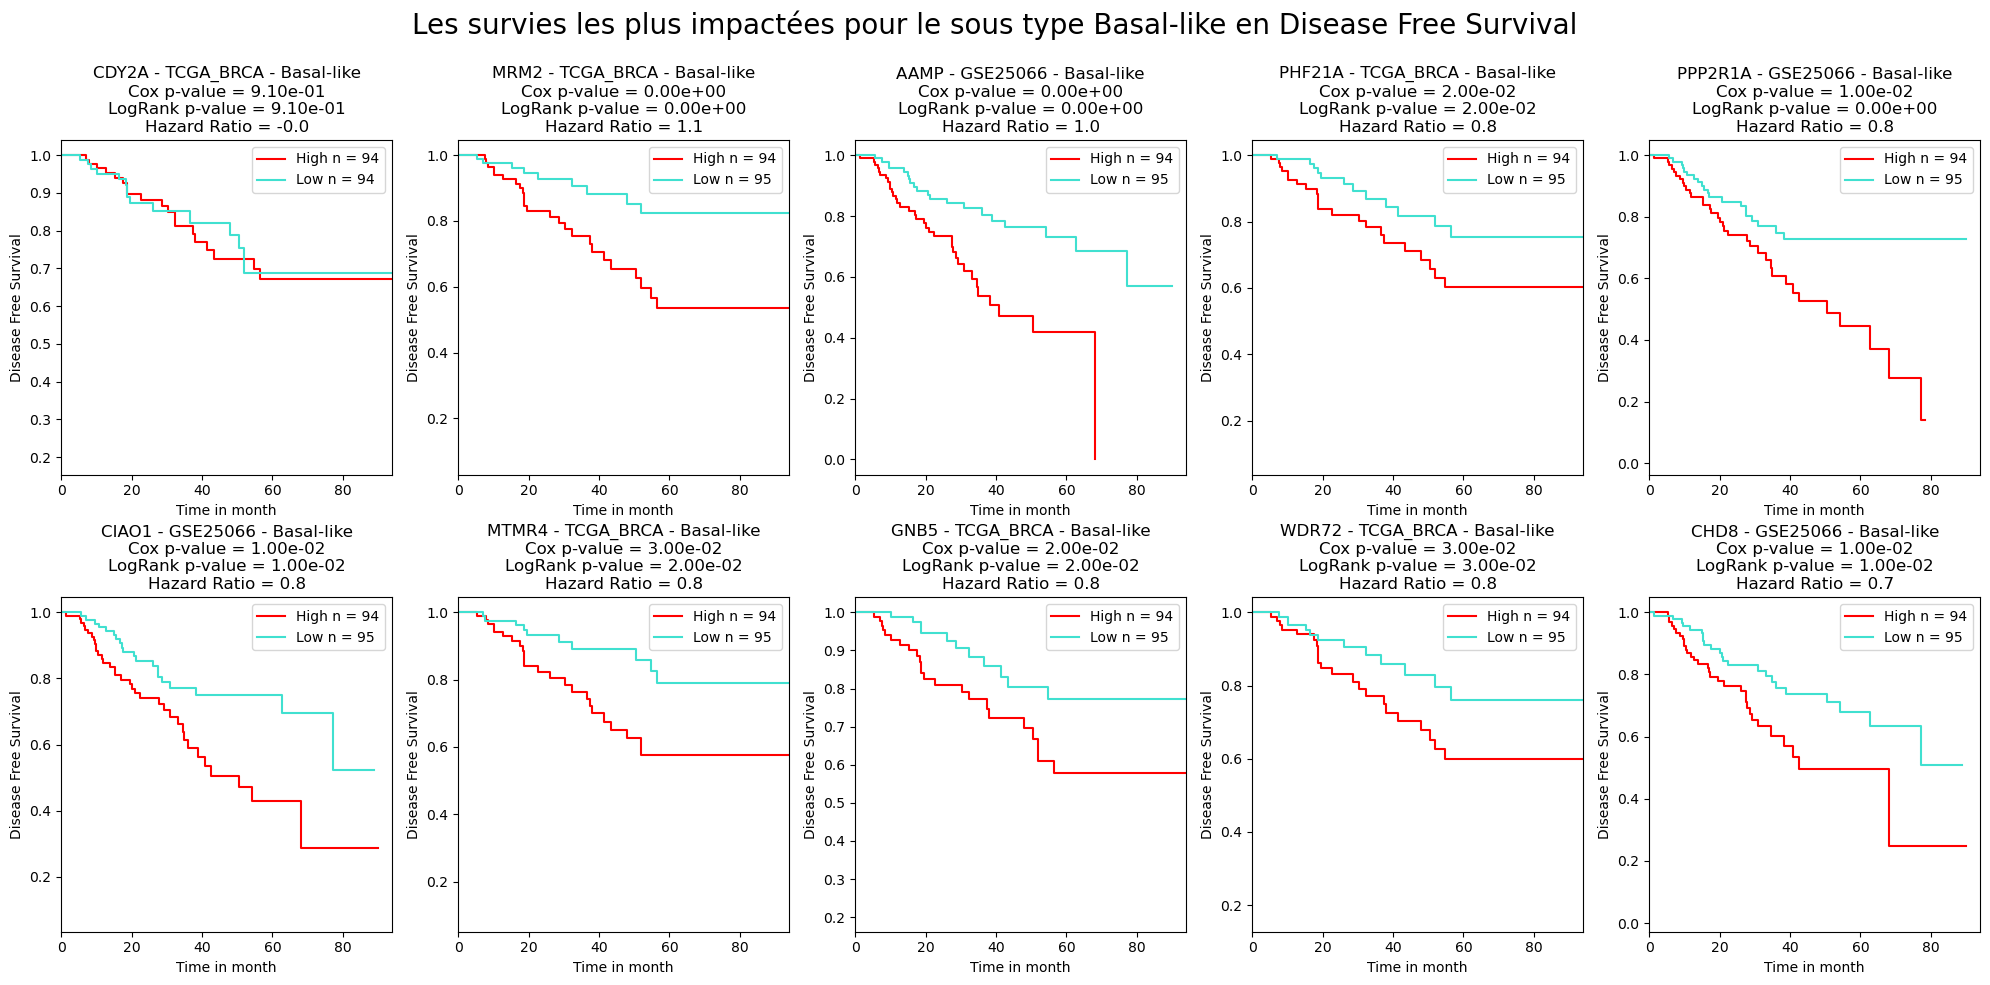

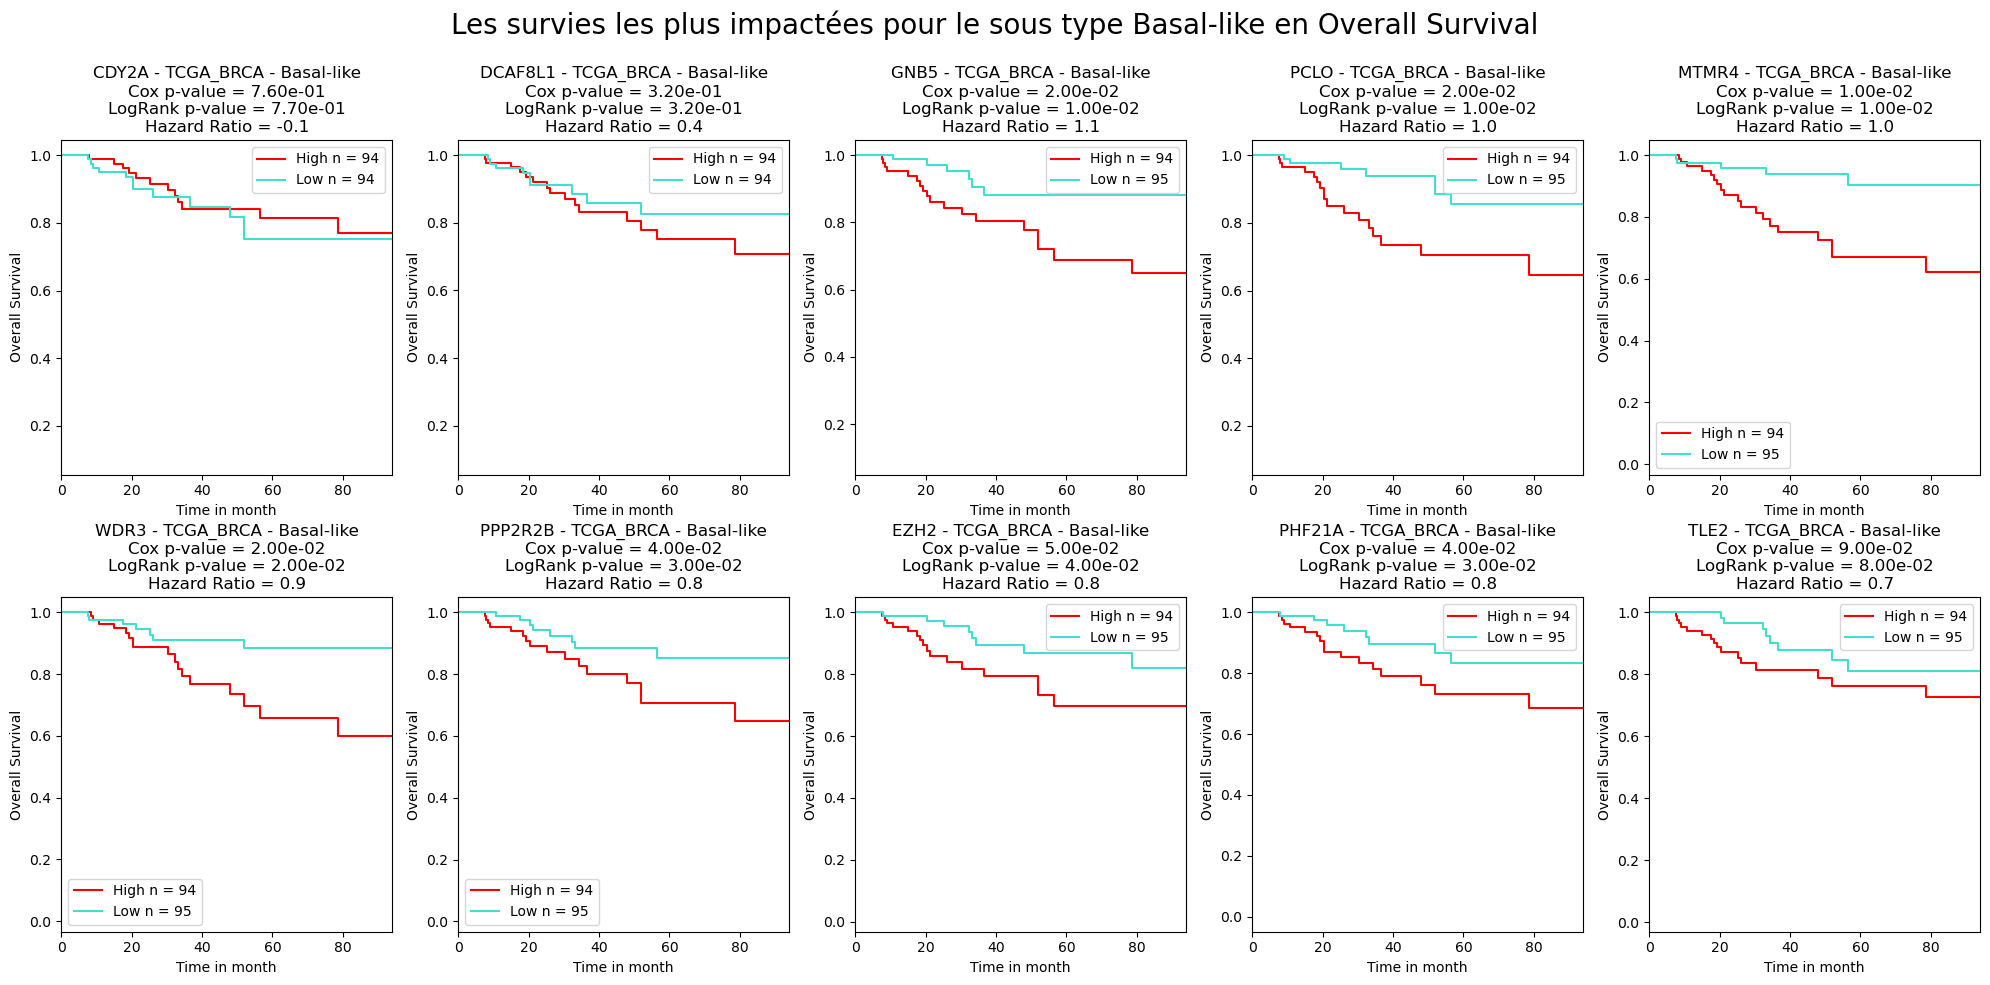

In [226]:
get_best_survie("Basal-like", "DFS")
get_best_survie("Basal-like", "OS")

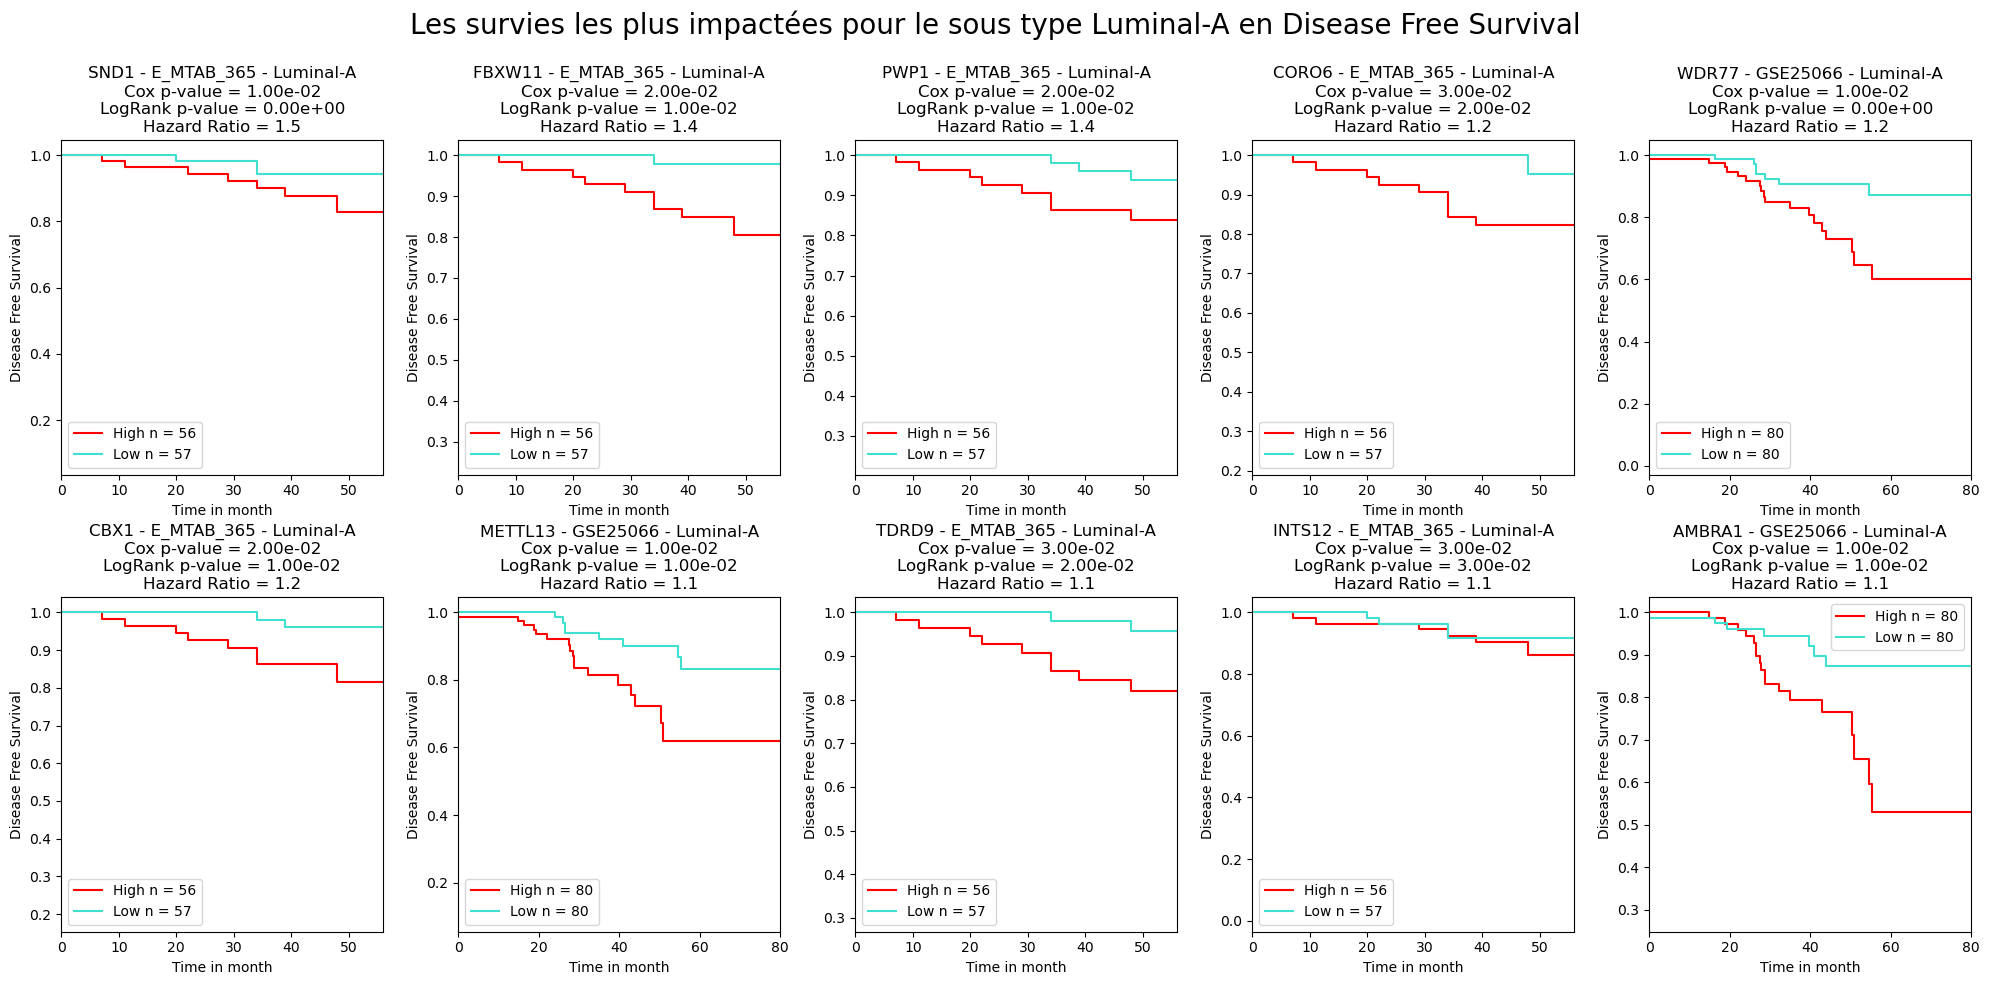

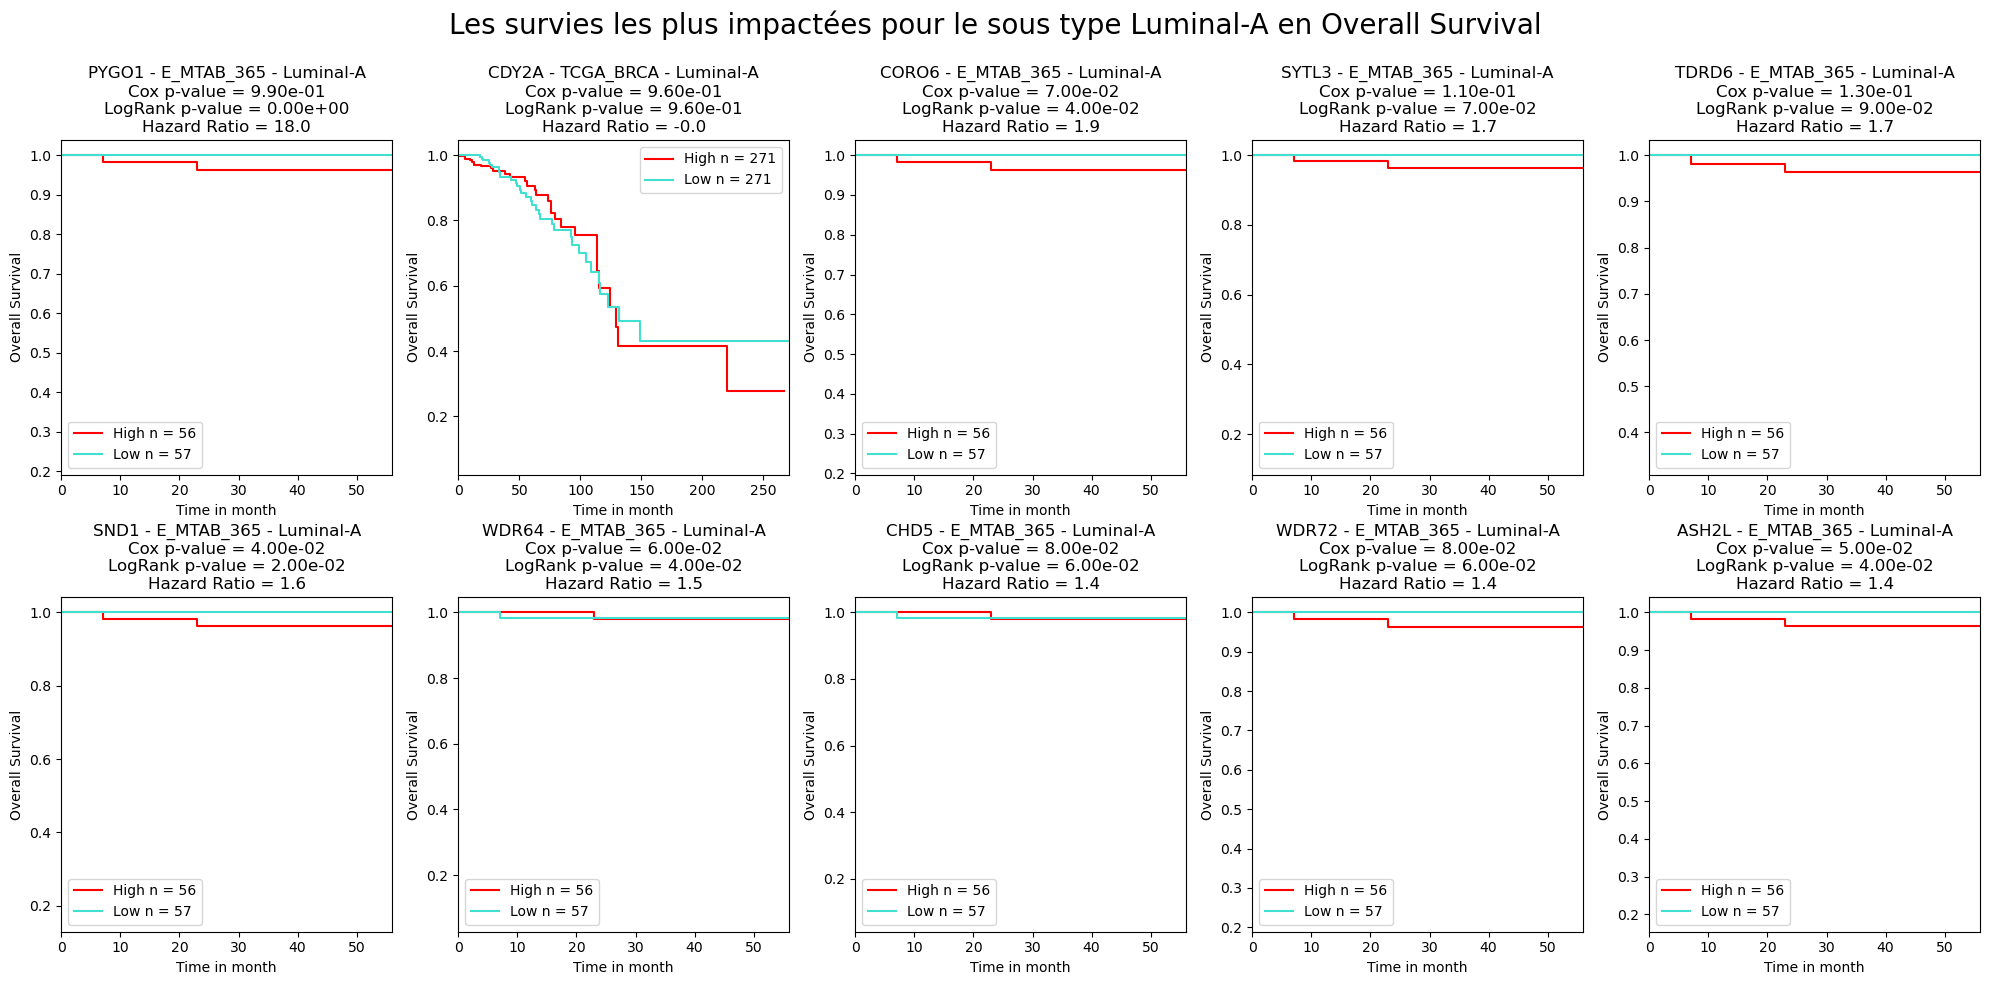

In [227]:
get_best_survie("Luminal-A", "DFS")
get_best_survie("Luminal-A", "OS")

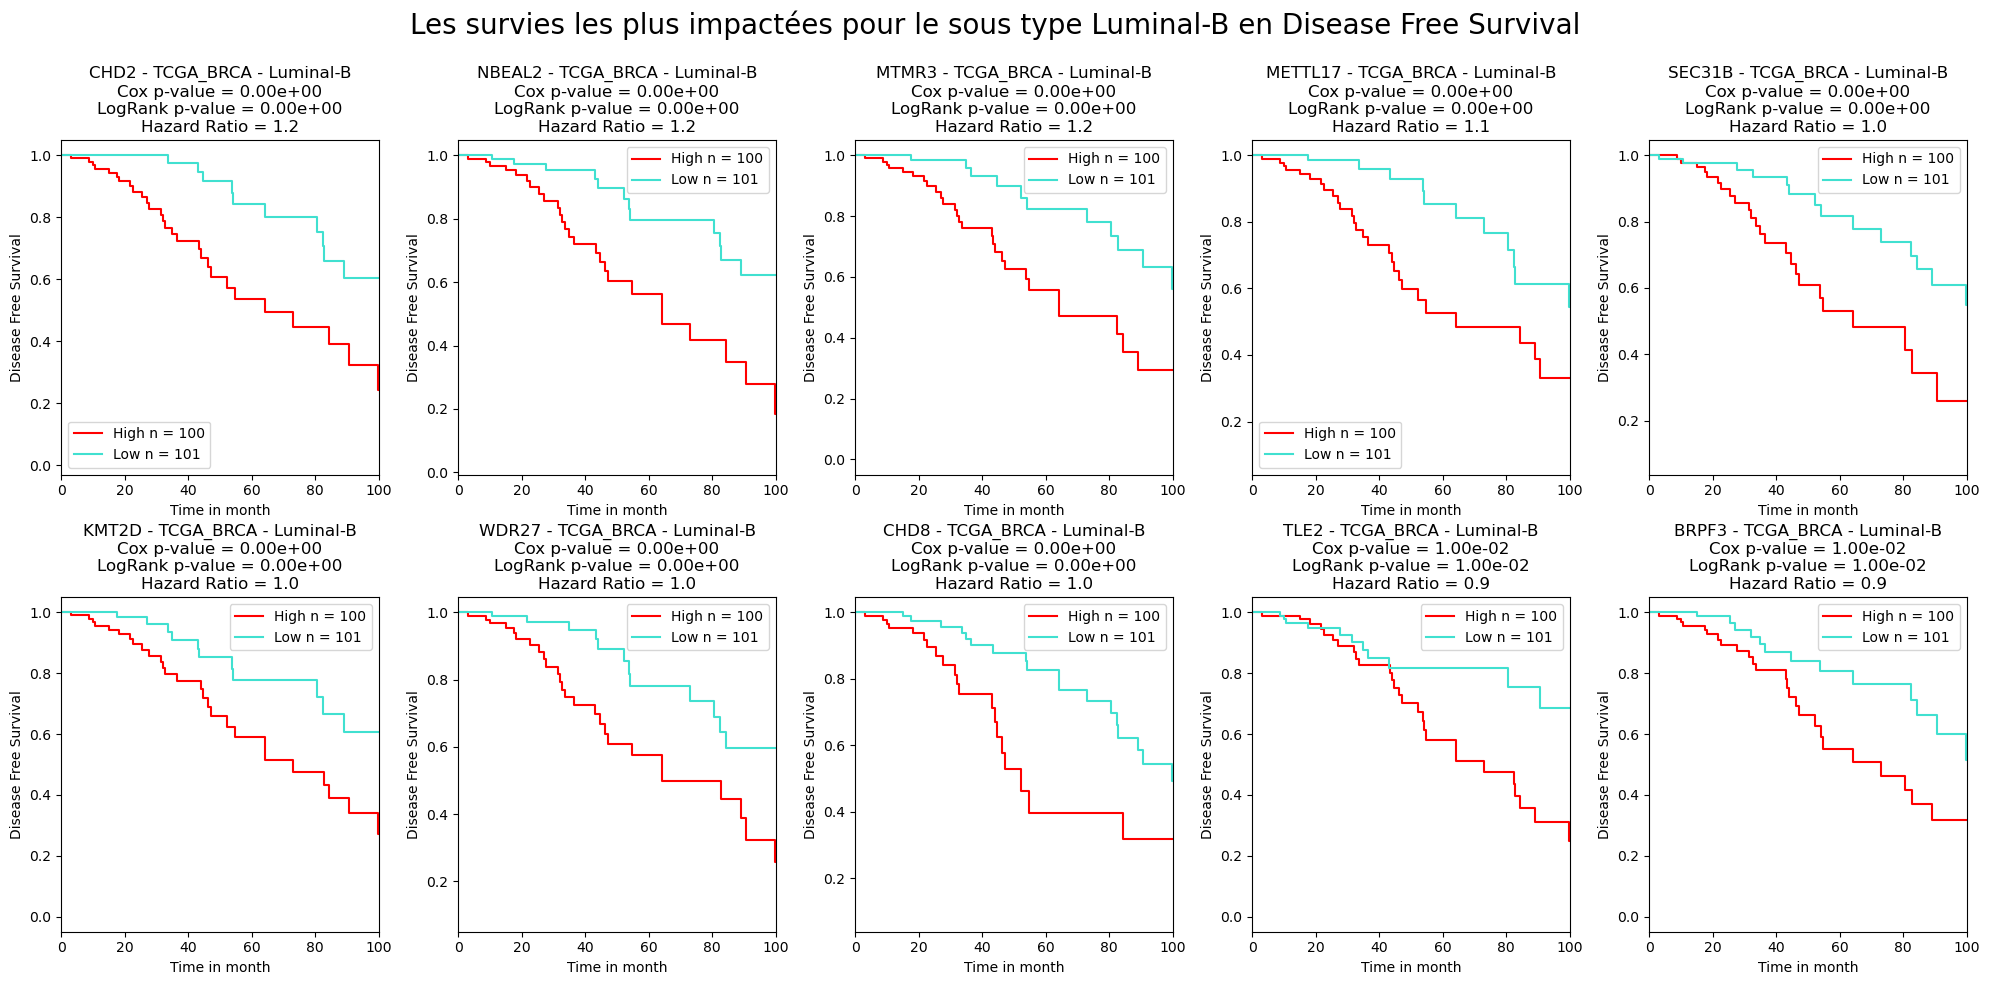

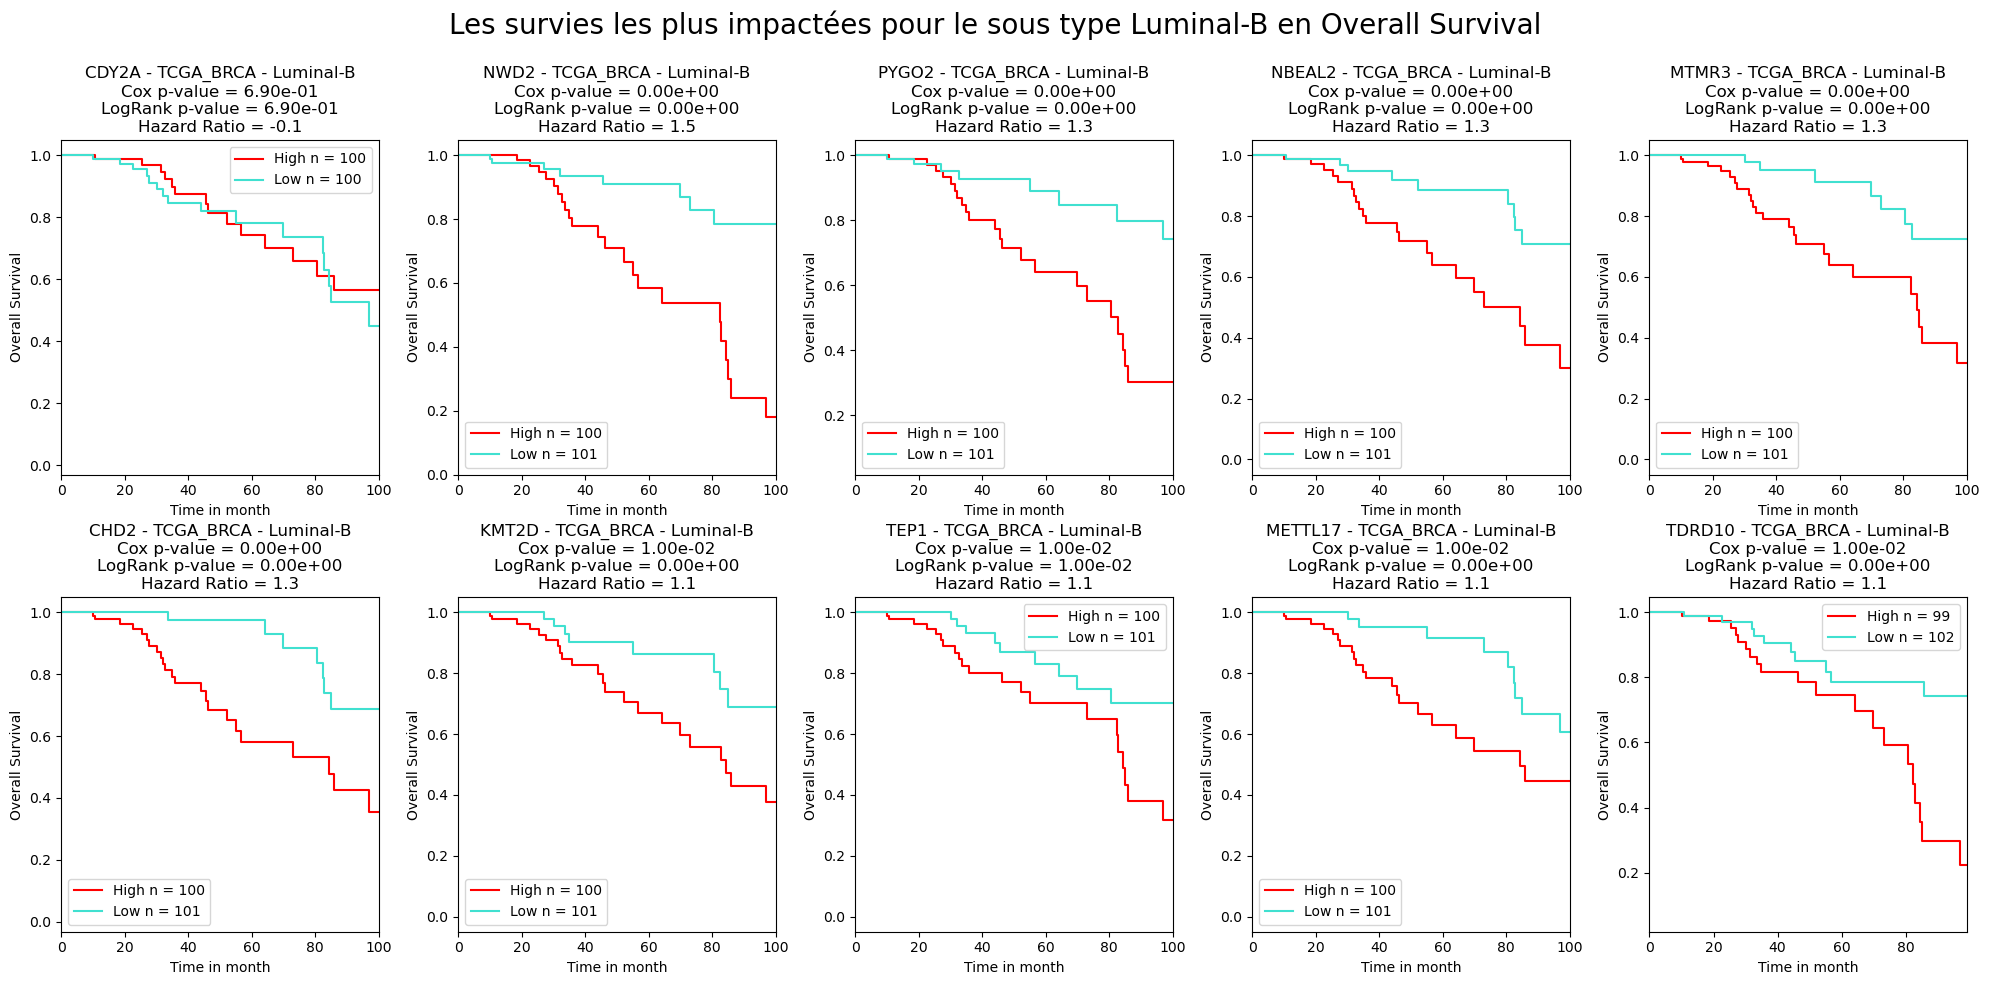

In [228]:
get_best_survie("Luminal-B", "DFS")
get_best_survie("Luminal-B", "OS")

Attention, il faut bien garder en tête qu'avec les résultats ci-dessus, nous avons uniquement les analyse de survie pour lesquelles le nombre d'observations est supérieur ou égal à 100

#### Comment sont répartis les échantillons et les sous-types moléculaires dans les différents jeux de données ?

In [132]:
eff = cancer.groupby("Dataset")[["Non-tumour", "All-tumours",	"Luminal-A", "Luminal-B", "HER2-enriched", "Basal-like"]].sum()
eff.loc['Total', :] = eff.sum(axis=0)
eff['Total'] = eff.sum(axis=1)
eff = eff.astype(int)
eff

,Non-tumour,All-tumours,Luminal-A,Luminal-B,HER2-enriched,Basal-like,Total
Dataset,,,,,,,
E-MTAB-365,0,537,153,131,56,99,976
GSE21653,0,266,89,49,24,75,503
GSE25066,0,508,160,78,37,189,972
GSE42568,0,104,26,19,19,26,194
Miller-2005,0,251,0,0,0,0,251
Naderi-Caldas-2007,0,113,0,0,0,0,113
TCGA-BRCA,113,1108,545,202,82,190,2240
Yau-2010,0,683,219,136,101,166,1305
Total,113,3570,1192,615,319,745,6554


In [158]:
df = eff.reset_index().drop("Total", axis=1).drop(8)
df = df.melt(id_vars=["Dataset"], var_name="Cancer", value_name="Nombre")
df = df.sort_values(by="Nombre", ascending=False)

In [167]:
eff.reset_index().drop(["Total","Dataset"], axis=1).drop(8)[["Luminal-A", "Luminal-B", "HER2-enriched", "Basal-like"]].sum()

Luminal-A        1192
Luminal-B         615
HER2-enriched     319
Basal-like        745
dtype: int64

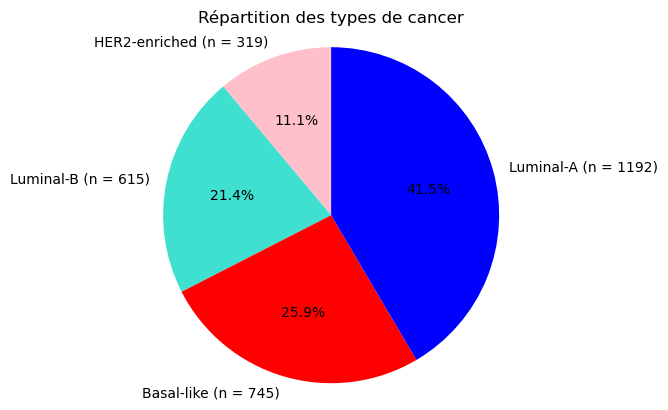

In [177]:
import matplotlib.pyplot as plt

labels = ['HER2-enriched', 'Luminal-B', 'Basal-like','Luminal-A']
sizes = [319, 615, 745, 1192]
labels_with_counts = [f'{label} (n = {size})' for label, size in zip(labels, sizes)]
colors = ['pink', 'turquoise', 'red', 'blue']


# Création du diagramme en camembert
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels_with_counts, colors=colors, autopct='%1.1f%%', startangle=90)

ax1.axis('equal')

plt.title('Répartition des types de cancer')
plt.show()

### Quels sont les gènes dont le niveau d’expression est associé à la survie de façon robuste, c’est-à-dire, avec validation dans plusieurs datasets ? 

# TEST

In [39]:
all_survie2 = df
all_survie2['conclusion'] = all_survie2.apply(lambda row: 'Significative' if (row['FDR_logrank'] < 0.1) or (row['FDR_Cox'] < 0.1) else 'Not Significative', axis=1)

In [59]:
all_survie2 = pd.read_pickle("Brouillons/BrouillonPython/res_DV.pkl")

In [189]:
all_survie2

,dataset,gene,soustype,typesurvie,pval_logRank,pval_Cox,FDR_logrank,FDR_Cox,HR,n,conclusion
0,GSE21653,EHMT2,HER2-enriched,DFS,0.00,1.0,0.0,1.0,18.6,22,Significative
1,GSE25066,FYCO1,HER2-enriched,DFS,0.00,1.0,0.0,1.0,18.3,37,Significative
2,GSE42568,UHRF2,Luminal-B,OS,0.01,1.0,0.05,1.0,18.3,19,Significative
3,GSE25066,DCAF10,HER2-enriched,DFS,0.01,1.0,0.025,1.0,18.2,37,Significative
4,GSE21653,PWWP2A,HER2-enriched,DFS,0.01,1.0,0.025,1.0,18.2,22,Significative
...,...,...,...,...,...,...,...,...,...,...,...
21759,GSE42568,TLE2,Luminal-B,OS,0.00,1.0,0.0,1.0,-18.4,19,Significative
21760,GSE42568,METTL26,Luminal-B,OS,0.00,1.0,0.0,1.0,-18.4,19,Significative
21761,GSE42568,NSD1,Luminal-B,OS,0.00,1.0,0.0,1.0,-18.4,19,Significative
21762,GSE42568,PRDM11,Luminal-B,OS,0.00,1.0,0.0,1.0,-18.7,19,Significative


In [179]:
all_survie2.dataset.value_counts()

TCGA_BRCA     5664
GSE42568      5630
E_MTAB_365    5630
GSE21653      2770
GSE25066      2070
Name: dataset, dtype: int64

Nous créeons une nouvelle colonne poids qui associe un poids à chaque dataset 

In [190]:
poids_dict = {
    'TCGA_BRCA' : 1,
    'GSE42568' : 5630/5664,
    'E_MTAB_365' : 5630/5664,
    'GSE21653' : 2770/5664,
    'GSE25066' : 2070/5664
}
all_survie2['poids'] = all_survie2['dataset'].apply(lambda x: poids_dict.get(x, 0))

-----------------------------------------------------------------------------------------------------------------------------

In [271]:
# Définition des datasets
dataset = ["GSE21653", "Miller", "Naderi_Caldas", "E_MTAB_365", "GSE25066", "GSE42568", "TCGA_BRCA", "Yau"]
dataset2 = ["GSE21653_EG", "Miller_EG", "Naderi_Caldas_EG", "E_MTAB_365_EG", "GSE25066_EG", "GSE42568_EG", "TCGA_BRCA_EG", "Yau_EG"]

In [272]:
df = pd.DataFrame(columns = ['dataset', 'dataset2', 'gene', 'soustype', 'pvCox','pvRank','conclusion', 'HR'])
for d,d2 in zip(dataset,dataset2):
    for g in globals()[d].gene_symbol.unique():
        for st in ["All-tumours", "Luminal-A", "Luminal-B", "HER2-enriched", "Basal-like"]:
            rank = logRank(d,d2,g,st,"OS")
            cox = Cox(d,d2,g,st,"OS")[0]
            ratio = Cox(d,d2,g,st,"OS")[1]
            if(isinstance(rank,str) or isinstance(cox,str)):
                nvl = {'dataset': d, 'dataset2': d2, 'gene': g, 'soustype': st,'pvCox':cox,'pvRank':rank,'conclusion': 'NaN', 'HR' : 'NaN'}
                df = df.append(nvl, ignore_index=True)
                break
            if(rank < 0.05 and cox < 0.05):
                nvl = {'dataset': d, 'dataset2': d2, 'gene': g, 'soustype': st,'pvCox':cox,'pvRank':rank, 'conclusion': 'All significatives','HR' : ratio}
                df = df.append(nvl, ignore_index=True)
                break
            if(rank > 0.05 and cox < 0.05):
                nvl = {'dataset': d, 'dataset2': d2, 'gene': g, 'soustype': st,'pvCox':cox,'pvRank':rank, 'conclusion': 'Cox siginificatif','HR' : ratio}
                df = df.append(nvl, ignore_index=True)
                break
            if(rank < 0.05 and cox > 0.05):
                nvl = {'dataset': d, 'dataset2': d2, 'gene': g, 'soustype': st,'pvCox':cox,'pvRank':rank, 'conclusion': 'LogRank siginificatif', 'HR' : ratio}
                df = df.append(nvl, ignore_index=True)
                break
            nvl = {'dataset': d, 'dataset2': d2, 'gene': g, 'soustype': st,'pvCox':cox,'pvRank':rank, 'conclusion': 'Not significative', 'HR' : ratio}
            df = df.append(nvl, ignore_index=True)

In [283]:
df['pvCox'] = df['pvCox'].replace("L", np.nan)
df['pvRank'] = df['pvRank'].replace("Les données de survie ne sont pas disponible",np.nan)
df['pvRank'] = df['pvRank'].replace("Les expressions data valent tous 0",np.nan)

In [286]:
df['FDR_rank'] = pd.NA
df['FDR_cox'] = pd.NA
grouped = df.groupby(['dataset', 'gene'])
for (dataset, gene), group in grouped:
    original_pvals_cox = group['pvCox'].values
    original_pvals_rank = group['pvRank'].values
    adj_pvals_cox = multipletests(original_pvals_cox, alpha=0.05, method='fdr_bh')[1]
    adj_pvals_rank = multipletests(original_pvals_rank, alpha=0.05, method='fdr_bh')[1]
    df.loc[group.index, 'FDR_cox'] = adj_pvals_cox
    df.loc[group.index, 'FDR_rank'] = adj_pvals_rank

In [211]:
df = pd.read_pickle('data/res.pkl')
df = df[["dataset","gene", "soustype", "conclusion", "HR","FDR_rank",'FDR_cox']]
df['HR'] = pd.to_numeric(df['HR'], errors='coerce')
df['FDR_rank'] = pd.to_numeric(df['FDR_rank'], errors='coerce')
df['FDR_cox'] = pd.to_numeric(df['FDR_cox'], errors='coerce')

In [212]:
def determine_conclusion(row):
    if pd.notnull(row['FDR_rank']) and pd.notnull(row['FDR_cox']):
        if row['FDR_rank'] < 0.05 and row['FDR_cox'] < 0.05:
            return 'Significative'
        else:
            return 'Not significative'
    elif pd.notnull(row['FDR_rank']):
        if row['FDR_rank'] < 0.05:
            return 'LogRank Significative'
        else:
            return 'LogRank Not Significative'
    elif pd.notnull(row['FDR_cox']):
        if row['FDR_cox'] < 0.05:
            return 'Cox Significative'
        else:
            return 'Cox Not Significative'
    else:
        return 'NaN'

df['conclusion'] = df.apply(determine_conclusion, axis=1)

In [213]:
best_final = df.sort_values(by = "HR", ascending=False)
pd.set_option('display.max_rows', 100)
outliers = best_final[0:39]
best_final = best_final[39:best_final.shape[0]]

In [192]:
pd.set_option('display.max_rows', 100)
all_survie2.sort_values(by = "HR", ascending=False)[55:]

,dataset,gene,soustype,typesurvie,pval_logRank,pval_Cox,FDR_logrank,FDR_Cox,HR,n,conclusion,poids
55,GSE42568,BMT2,HER2-enriched,OS,0.00,0.00,0.0,0.0,3.2,19,Significative,0.993997
56,E_MTAB_365,WDR4,HER2-enriched,OS,0.00,0.01,0.0,0.05,2.8,48,Significative,0.993997
57,GSE42568,FGD5,Luminal-B,DFS,0.01,0.03,0.1,0.3,2.4,19,Significative,0.993997
58,GSE21653,SETD1B,HER2-enriched,DFS,0.02,0.05,0.1,0.225,2.2,22,Significative,0.489054
59,GSE42568,RBBP4,Luminal-B,DFS,0.02,0.04,0.06,0.1,2.2,19,Significative,0.993997
...,...,...,...,...,...,...,...,...,...,...,...,...
21759,GSE42568,TLE2,Luminal-B,OS,0.00,1.00,0.0,1.0,-18.4,19,Significative,0.993997
21760,GSE42568,METTL26,Luminal-B,OS,0.00,1.00,0.0,1.0,-18.4,19,Significative,0.993997
21761,GSE42568,NSD1,Luminal-B,OS,0.00,1.00,0.0,1.0,-18.4,19,Significative,0.993997
21762,GSE42568,PRDM11,Luminal-B,OS,0.00,1.00,0.0,1.0,-18.7,19,Significative,0.993997


In [193]:
all_survie2.sort_values(by = "HR", ascending=False)[55:][["dataset", "HR"]][abs(all_survie2.sort_values(by = "HR", ascending=False)[55:].HR) > 0].dataset.value_counts()

GSE42568      5249
E_MTAB_365    5008
TCGA_BRCA     4920
GSE21653      2508
GSE25066      1885
Name: dataset, dtype: int64

Nous allons compter dans combien de jeux de données distincts se repète la même conclusion pour un gène. Nous allons créer 3 tableaux : 
- res_all = englobe les 2 types de survie (OS et DFS)
- res_OS = englobe seulement les OS
- res_DFS = englobe seulement les DFS

In [198]:
res_all = all_survie2.groupby(["gene", "conclusion"])["dataset"].nunique().reset_index()
res_OS = all_survie2[all_survie2.typesurvie == "OS"].groupby(["gene", "conclusion"])["dataset"].nunique().reset_index()
res_DFS = all_survie2[all_survie2.typesurvie == "DFS"].groupby(["gene", "conclusion"])["dataset"].nunique().reset_index()

In [ ]:
pd.set_option('display.max_rows', None)
res_OS[res_OS.conclusion == "Significative"].sort_values(by='dataset', ascending=False)

In [ ]:
res_OS[res_OS.conclusion == "Not Significative"].sort_values(by='dataset', ascending=False)

In [ ]:
res_DFS[res_DFS.conclusion == "Significative"].sort_values(by='dataset', ascending=False)

In [ ]:
res_DFS[res_DFS.conclusion == "Not Significative"].sort_values(by='dataset', ascending=False)

In [214]:
pd.set_option('display.max_rows', 10)
res = best_final[(best_final.conclusion != 'NaN')][0:best_final.shape[0]].groupby(["gene","conclusion"])["dataset"].nunique().reset_index().sort_values(by = 'dataset', ascending = False)[0:1000]

In [215]:
gg = pd.concat([res[res.conclusion == "Not significative"].head(10), 
                res[res.conclusion != "Not significative"][res.conclusion != "NaN"].head(10)])

C:\Users\zergu\AppData\Local\Temp\ipykernel_4804\4157034903.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [216]:
f = f[['dataset', 'gene', 'soustype', 'conclusion', 'HR']]
ff = f[['dataset', 'gene', 'HR']]

In [217]:
# Trier les données par 'dataset', 'gene', et la valeur absolue de 'HR' en ordre décroissant
ff_mod = ff.assign(abs_HR=ff['HR'].abs()).sort_values(by=['dataset', 'gene', 'abs_HR'], ascending=[True, True, False])
# Suppression des doublons pour garder la ligne avec le max absolu de 'HR' pour chaque 'dataset' et 'gene'
ff = ff_mod.drop_duplicates(subset=['dataset', 'gene']).drop(columns=['abs_HR'])


In [218]:
ff.pivot("dataset", "gene", "HR")

gene,ATG16L2,CBX5,CBX6,CDC20B,MSH6,MSL3,PPP2R2B,RAI1,RPH3AL,SETD9,SETDB2,SETMAR,SPAG16,TAF3,THUMPD3,TRMT9B,UBR7,UHRF2,WDR3,WDR81
dataset,,,,,,,,,,,,,,,,,,,,
E_MTAB_365,0.5,0.9,0.8,0.6,-1.1,1.1,-1.4,0.8,0.4,0.2,-0.8,-0.4,-0.7,0.9,1.5,-1.6,-0.9,0.8,0.8,-0.8
GSE42568,0.9,0.6,-0.8,-1.1,0.3,1.6,-1.7,-1.0,0.7,0.7,-1.2,-0.8,-0.7,NaN,1.8,NaN,0.9,0.9,-1.5,0.1
TCGA_BRCA,0.3,-0.2,0.2,0.4,-0.8,0.8,0.6,NaN,-0.9,-0.7,-0.6,-0.9,0.6,-0.5,-1.2,0.4,NaN,NaN,0.9,-0.8


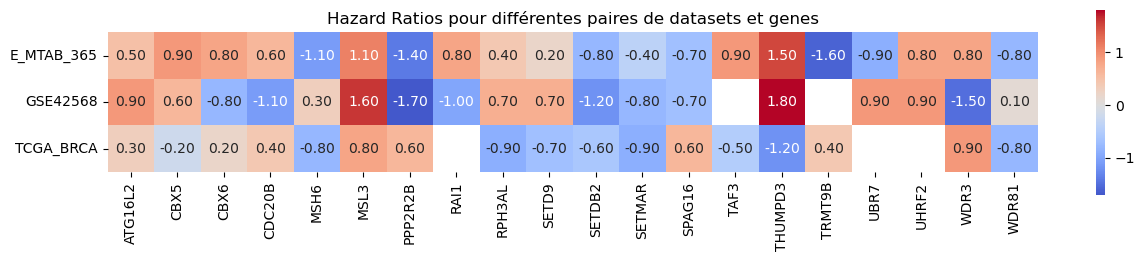

In [219]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12)) 
sns.heatmap(ff.pivot("dataset", "gene", "HR"), annot=True, cmap="coolwarm", fmt=".2f",center = 0,square = True,cbar_kws={"shrink": 0.2})
plt.title("Hazard Ratios pour différentes paires de datasets et genes")
plt.xlabel('')
plt.ylabel('')
plt.show()

### Nous pouvons créer une fonction qui généralise le travail fait

In [218]:
# Prérequis
df = pd.read_pickle('data/res.pkl')
df = df[["dataset","gene", "soustype", "conclusion", "HR"]]
df['HR'] = pd.to_numeric(df['HR'], errors='coerce')

best_final = df.sort_values(by = "HR", ascending=False)
outliers = best_final[0:39]
best_final = best_final[39:best_final.shape[0]]
best_final.head()

,dataset,gene,soustype,conclusion,HR
4734,GSE42568,EED,HER2-enriched,All significatives,2.0
4536,GSE42568,PPP2R1B,HER2-enriched,All significatives,2.0
5750,GSE42568,WDR35,Luminal-B,LogRank siginificatif,2.0
2261,E_MTAB_365,WDR43,HER2-enriched,All significatives,2.0
4986,GSE42568,DIDO1,Luminal-B,LogRank siginificatif,2.0


C:\Users\zergu\AppData\Local\Temp\ipykernel_4804\3584322347.py:8: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\zergu\AppData\Local\Temp\ipykernel_4804\3584322347.py:11: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\zergu\AppData\Local\Temp\ipykernel_4804\3584322347.py:11: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\zergu\AppData\Local\Temp\ipykernel_4804\3584322347.py:11: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\zergu\AppData\Local\Temp\ipykernel_4804\3584322347.py:11: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\zergu\AppData\Local\Temp\ipykernel_4804\3584322347.py:11: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

C:\Users\zergu\AppData\Local\Temp\ipykernel_4804\3584322347.py:11: UserWarning:

Boolean Series key will be reindexed to match Data

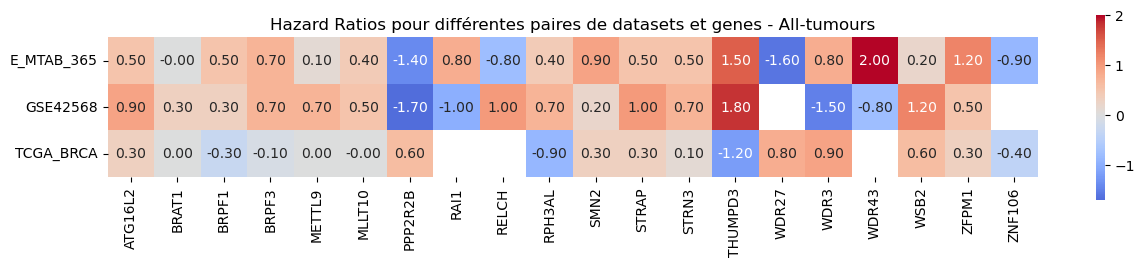

<module 'matplotlib.pyplot' from 'c:\\Users\\zergu\\.conda\\envs\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [219]:
def plot_HR(soustype):
    best_final = df.sort_values(by = "HR", ascending=False)
    best_final = best_final[39:best_final.shape[0]]
    if(soustype != "All-tumours"):
        best_final = best_final[best_final.soustype == soustype][best_final.HR > -5]
    res = best_final.groupby(["gene","conclusion"])["dataset"].nunique().reset_index().sort_values(by = 'dataset', ascending = False)
    gg = pd.concat([res[res.conclusion == "Not significative"].head(10),
                     res[res.conclusion != "Not significative"][res.conclusion != "NaN"].head(10)])
    f = pd.DataFrame()
    for g,ccl in zip(gg.gene,gg.conclusion):
         f = pd.concat([f,best_final[best_final.gene == g][best_final.conclusion == ccl]])
    f = f.reset_index()
    f = f[['dataset', 'gene', 'HR']]
    f_mod = f.assign(abs_HR=best_final['HR'].abs()).sort_values(by=['dataset', 'gene', 'abs_HR'], ascending=[True, True, False])
    f = f_mod.drop_duplicates(subset=['dataset', 'gene']).drop(columns=['abs_HR'])

    plt.figure(figsize=(15, 12)) 
    sns.heatmap(f.pivot("dataset", "gene", "HR"), annot=True, cmap="coolwarm", fmt=".2f",center = 0,square = True,cbar_kws={"shrink": 0.2})
    plt.title(f"Hazard Ratios pour différentes paires de datasets et genes - {soustype}")
    plt.xlabel('')
    plt.ylabel('')
    plt.show()
    return plt

# Test pour All-tumours
plot_HR("All-tumours")

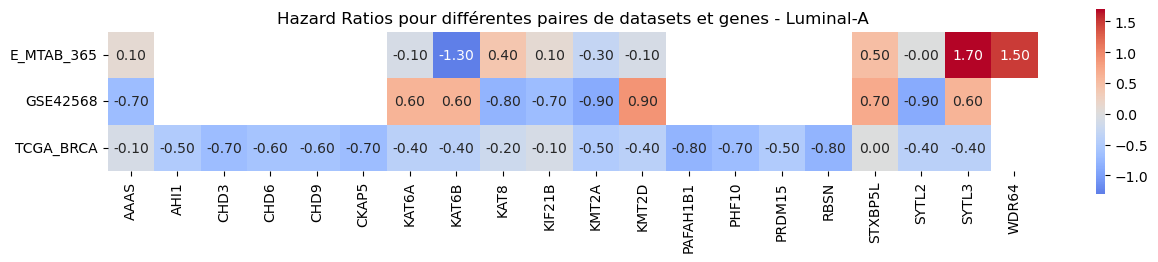

<module 'matplotlib.pyplot' from 'c:\\Users\\zergu\\.conda\\envs\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [316]:
# Test pour Luminal-A
plot_HR("Luminal-A")

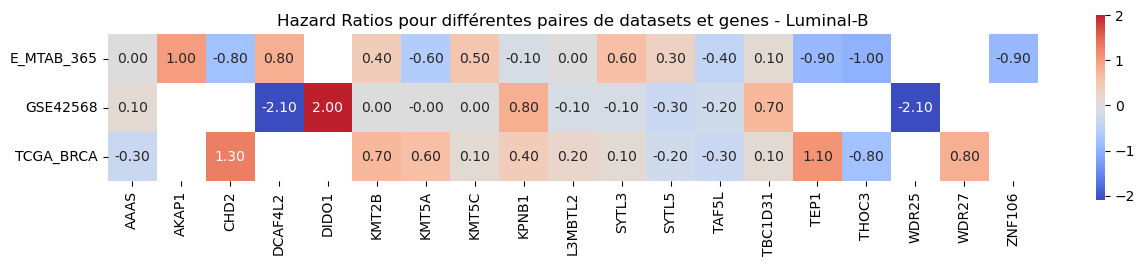

<module 'matplotlib.pyplot' from 'c:\\Users\\zergu\\.conda\\envs\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [263]:
# Test pour Luminal-A
plot_HR("Luminal-B")

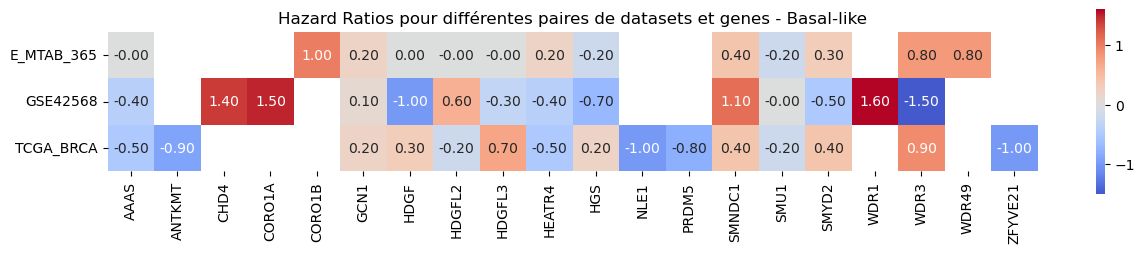

<module 'matplotlib.pyplot' from 'c:\\Users\\zergu\\.conda\\envs\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [264]:
# Test pour Luminal-A
plot_HR("Basal-like")

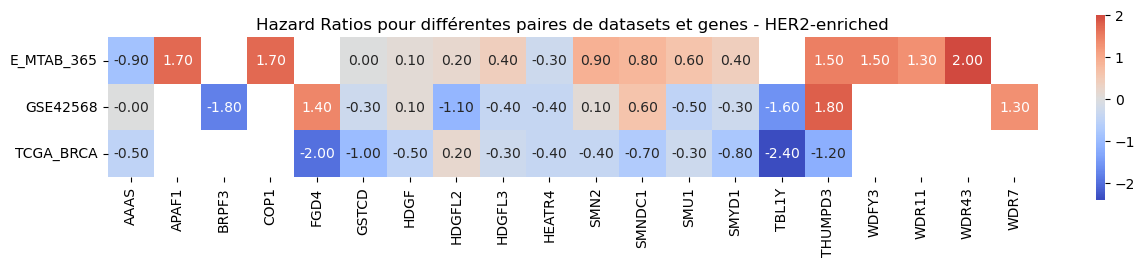

<module 'matplotlib.pyplot' from 'c:\\Users\\zergu\\.conda\\envs\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [265]:
# Test pour Luminal-A
plot_HR("HER2-enriched")

### Réaliser l'heatmap avec les stades de cancer, les sous types moléculaires ...

In [266]:
sampleLA = cancer[cancer['Luminal-A'] == 1]['Sample']
sampleLB = cancer[cancer['Luminal-B'] == 1]['Sample']
sampleHER2 = cancer[cancer['HER2-enriched'] == 1]['Sample']
sampleBL = cancer[cancer['Basal-like'] == 1]['Sample']
sampleS1 = cancer[cancer['Stage-I'] == 1]['Sample']
sampleS2 = cancer[cancer['Stage-II'] == 1]['Sample']
sampleS3 = cancer[cancer['Stage-III'] == 1]['Sample']
sampleS4 = cancer[cancer['Stage-IV'] == 1]['Sample']
sampleN0 = cancer[cancer['N0'] == 1]['Sample']
sampleN1 = cancer[cancer['N1'] == 1]['Sample']
sampleN2 = cancer[cancer['N2'] == 1]['Sample']
sampleN3 = cancer[cancer['N3'] == 1]['Sample']
sampleM1 = cancer[cancer['M1'] == 1]['Sample']

In [267]:
pd.set_option('display.max_rows', 10)

In [268]:
# Recup les données de survie
TCGA_BRCA_EG[TCGA_BRCA_EG.id_sample.isin(sampleLA)][
    ["id_sample","os_months","os_censor","dfs_months","dfs_censor"]]

,id_sample,os_months,os_censor,dfs_months,dfs_censor
1,TCGA-A8-A0AD-01A,38.57,0.0,38.57,0.0
3,TCGA-C8-A26Z-01A,15.67,0.0,15.67,0.0
5,TCGA-AO-A12A-01A,103.73,0.0,103.73,0.0
6,TCGA-E2-A1L9-01A,19.93,0.0,19.93,0.0
7,TCGA-AC-A8OS-01A,2.33,0.0,2.33,0.0
...,...,...,...,...,...
1202,TCGA-A2-A0YF-01A,51.17,0.0,51.17,0.0
1203,TCGA-A8-A07P-01A,11.13,0.0,11.13,0.0
1210,TCGA-A8-A08O-01A,31.43,0.0,31.43,0.0
1213,TCGA-B6-A0RO-01A,164.30,0.0,164.30,0.0


In [269]:
pd.concat([TCGA_BRCA['gene_symbol'],
           TCGA_BRCA[TCGA_BRCA_EG[TCGA_BRCA_EG.id_sample.isin(sampleLA)]['id_sample']]],
           axis = 1)

,gene_symbol,TCGA-A8-A0AD-01A,TCGA-C8-A26Z-01A,TCGA-AO-A12A-01A,TCGA-E2-A1L9-01A,TCGA-AC-A8OS-01A,TCGA-B6-A0X4-01A,TCGA-AN-A046-01A,TCGA-E2-A10A-01A,TCGA-A7-A0D9-01A,...,TCGA-AC-A4ZE-01A,TCGA-EW-A1J1-01A,TCGA-LD-A7W5-01A,TCGA-C8-A12X-01A,TCGA-BH-A0E1-01A,TCGA-A2-A0YF-01A,TCGA-A8-A07P-01A,TCGA-A8-A08O-01A,TCGA-B6-A0RO-01A,TCGA-AC-A3QP-01A
8,AAMP,5.199193,5.014962,5.180566,4.576431,5.265369,5.300581,5.665757,5.378609,5.511538,...,5.786460,5.119696,6.214867,5.733867,5.535618,4.536563,5.914031,4.835914,5.818580,5.890096
245,APAF1,2.057624,2.748526,1.983422,1.701017,2.018634,1.586933,1.516217,2.506450,1.936892,...,1.805746,2.068636,1.451488,2.106717,1.272382,2.764601,2.087734,2.470693,2.236401,0.994218
254,AIRE,0.000000,0.013641,0.016639,0.012068,0.062812,0.000000,0.004897,0.005328,0.000000,...,0.005616,0.012640,0.030548,0.011353,0.006047,0.008630,0.005041,0.006908,0.000000,0.011353
371,RERE,3.637506,4.162468,3.745689,3.407910,4.217114,4.187633,3.282721,3.177902,3.800600,...,3.598603,3.813863,4.074617,3.588972,3.531781,3.455268,3.554699,3.719129,3.247973,3.056653
426,ATR,1.396050,1.437973,1.475085,1.290601,1.293370,1.285876,1.037382,1.771379,1.652464,...,1.472592,1.257252,0.916477,1.277092,1.250052,1.667483,1.452174,1.751078,1.457962,0.909965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26081,METTL24,0.391328,0.321697,0.266996,0.142740,0.396927,0.000000,0.136191,0.145351,0.134352,...,0.267955,0.157691,0.450697,0.115965,0.277390,0.088820,0.354339,0.516318,0.265077,0.221692
26577,CSKMT,0.943584,0.374956,1.178045,1.156008,1.125982,1.418190,0.927821,0.721766,1.177790,...,1.020484,1.313014,1.133629,0.967906,1.128821,0.487486,0.811224,1.374678,1.145090,2.172967
27305,TDRD15,0.000000,0.000000,0.000000,0.002595,0.012497,0.000000,0.000000,0.020484,0.007770,...,0.003602,0.002739,0.000000,0.000000,0.007913,0.000000,0.000000,0.000000,0.000000,0.000000
27744,METTL15P1,0.326422,1.361151,0.962882,0.833173,0.923035,0.804549,0.544386,1.078542,0.668210,...,0.845430,1.014355,0.434241,0.649478,0.502432,1.445409,1.061500,1.125453,0.815084,0.297602


In [270]:
# Les échantillons Non-tumour dans le jeu de données TCGA_BRCA
cancer['Sample'][cancer['Non-tumour'] == 1][cancer.Dataset == "TCGA-BRCA"]
# Les échantillons All-tumours
cancer['Sample'][cancer['All-tumours'] == 1][cancer.Dataset == "TCGA-BRCA"]

113     TCGA-3C-AAAU-01A
114     TCGA-3C-AALI-01A
115     TCGA-3C-AALJ-01A
116     TCGA-3C-AALK-01A
117     TCGA-4H-AAAK-01A
              ...       
1216    TCGA-WT-AB44-01A
1217    TCGA-XX-A899-01A
1218    TCGA-XX-A89A-01A
1219    TCGA-Z7-A8R5-01A
1220    TCGA-Z7-A8R6-01A
Name: Sample, Length: 1108, dtype: object

Récupérer les noms de colonne dans la jeu de données cancer où ka valeur 1 est spécifiée !

In [271]:
d = []

for index, row in cancer.iterrows():
    sample = row['Sample']
    cols_with_1 = row[row == 1].index.tolist()
    cols_with_1 = [col for col in cols_with_1 if col != 'Sample']
    d.append([sample, cols_with_1])

d = pd.DataFrame(d, columns=['Sample', 'Columns_With_1'])

In [273]:
t = pd.concat([TCGA_BRCA['gene_symbol'],
           TCGA_BRCA[TCGA_BRCA_EG[TCGA_BRCA_EG.id_sample.isin(sampleLA)]['id_sample']]
           ],
           axis = 1)

In [275]:
# Test pour le gène AAMP dans le dataset TCGA-BRCA
test = t.iloc[0].reset_index().merge(d, left_on='index', right_on='Sample').drop('Sample', axis=1)
test.columns = ["Sample", "Expression", "Subtypes"]

Nous réalisons un premier tableau pour les OS

In [315]:
df_matrix_HR = pd.DataFrame(columns = ['dataset', 'gene', 'type', 'HR'])
for d,d2 in zip(dataset,dataset2):
    for g in globals()[d].gene_symbol.unique():
        for st in ["All-tumours", "Luminal-A", "Luminal-B", "HER2-enriched", "Basal-like", 'Stage-I', 'Stage-II',
       'Stage-III', 'Stage-IV', 'N0', 'N1', 'N2', 'N3', 'M1']:
            ratio = Cox(d,d2,g,st,"OS")[1]
            if(isinstance(ratio,str)):
                nvl = {'dataset': d, 'gene': g, 'type': st, 'HR' : 'NaN'}
                df_matrix_HR = df_matrix_HR.append(nvl, ignore_index=True)
                break
            nvl = {'dataset': d, 'gene': g, 'type': st, 'HR' : ratio}
            df_matrix_HR = df_matrix_HR.append(nvl, ignore_index=True)

In [ ]:
df_matrix_HR = pd.read_pickle("data/matrixHR")
df_matrix_HR['HR'] = pd.to_numeric(df_matrix_HR['HR'], errors='coerce')

Puis un Second pour les DFS

In [446]:
df_matrix_HR_DFS = pd.DataFrame(columns = ['dataset', 'gene', 'type', 'HR'])
for d,d2 in zip(dataset,dataset2):
    for g in globals()[d].gene_symbol.unique():
        for st in ["All-tumours", "Luminal-A", "Luminal-B", "HER2-enriched", "Basal-like", 'Stage-I', 'Stage-II',
       'Stage-III', 'Stage-IV', 'N0', 'N1', 'N2', 'N3', 'M1']:
            ratio = Cox(d,d2,g,st,"DFS")[1]
            if(isinstance(ratio,str)):
                nvl = {'dataset': d, 'gene': g, 'type': st, 'HR' : 'NaN'}
                df_matrix_HR_DFS = df_matrix_HR_DFS.append(nvl, ignore_index=True)
                break
            nvl = {'dataset': d, 'gene': g, 'type': st, 'HR' : ratio}
            df_matrix_HR_DFS = df_matrix_HR_DFS.append(nvl, ignore_index=True)

In [ ]:
df_matrix_HR_DFS.to_pickle('data/matrixHR_DFS')

In [332]:
df_matrix_HR_DFS = pd.read_pickle("data/matrixHR_DFS")
df_matrix_HR_DFS['HR'] = pd.to_numeric(df_matrix_HR_DFS['HR'], errors='coerce')

On cherche à afficher la matrice pour un dataset donné

In [378]:
# Exemple avec TCGA
df_matrix_HR[df_matrix_HR.dataset == "TCGA_BRCA"].pivot("gene", "type", "HR")

type,All-tumours,Basal-like,HER2-enriched,Luminal-A,Luminal-B,M1,N0,N1,N2,N3,Stage-I,Stage-II,Stage-III,Stage-IV
gene,,,,,,,,,,,,,,
AAAS,0.1,-0.5,-0.5,-0.1,-0.3,0.2,-0.2,0.2,0.3,0.6,-0.5,0.3,-0.1,0.7
AAMP,0.0,0.4,-0.8,0.0,0.1,-0.7,0.1,0.1,0.3,-0.4,-0.1,0.1,0.2,-0.6
AHI1,-0.2,0.4,-0.5,-0.5,-0.1,1.3,-0.3,-0.3,-0.2,1.6,-1.1,-0.4,0.2,0.9
AIRE,0.1,0.1,1.0,-0.1,0.5,1.0,0.5,-0.2,-0.2,0.5,1.1,-0.1,-0.2,0.3
AKAP1,-0.2,-0.1,-0.4,0.0,-0.3,0.7,-0.1,-0.7,0.3,-0.7,0.5,-0.7,0.1,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZFYVE9,0.1,-0.0,0.4,-0.1,0.2,1.6,0.2,-0.4,0.4,0.5,0.0,-0.2,0.6,0.8
ZMYND11,-0.1,-0.4,-0.8,-0.1,0.1,0.8,0.2,-0.3,-0.3,0.2,-0.1,-0.3,-0.0,0.4
ZMYND8,-0.0,0.7,-0.8,-0.2,0.5,-0.1,-0.3,-0.1,0.0,0.5,-0.3,0.0,0.1,0.3


Nous allons garder les 50 gènes qui ont la moyenne la plus elevée en valeurs absolue

In [397]:
HR_moy = []
for index, row in df_matrix_HR[df_matrix_HR.dataset == "TCGA_BRCA"].pivot("gene", "type", "HR").reset_index().drop('gene', axis=1).iterrows():
    row_numeric = pd.to_numeric(row, errors='coerce')
    moy_abs = np.round(row_numeric.abs().mean(),2)
    HR_moy.append(moy_abs)

In [406]:
df_matrix_HR[df_matrix_HR.dataset == "TCGA_BRCA"].pivot("gene", "type", "HR").reset_index().iloc[np.argsort(HR_moy)[-50:]].set_index('gene').dropna(how='all')

type,All-tumours,Basal-like,HER2-enriched,Luminal-A,Luminal-B,M1,N0,N1,N2,N3,Stage-I,Stage-II,Stage-III,Stage-IV
gene,,,,,,,,,,,,,,
BOP1,-0.0,-0.7,0.1,0.2,-0.2,-0.5,0.2,-0.0,0.3,-2.7,0.7,0.0,-0.3,-1.5
TLE3,0.2,0.4,-1.1,0.0,0.6,0.4,0.2,0.3,0.8,0.9,0.5,0.1,0.7,1.2
METTL22,0.0,-0.7,0.9,0.1,-0.2,1.9,-0.2,0.1,-0.2,1.4,0.2,-0.2,0.2,1.1
PRDM11,0.3,0.4,-0.3,-0.0,0.7,0.9,0.6,-0.4,0.3,1.5,0.7,-0.1,0.6,0.8
TBL1X,-0.3,-0.3,-0.7,-0.1,-0.6,0.9,-0.2,-0.5,-0.9,1.2,0.3,-0.5,0.2,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RUFY2,-0.1,0.2,-0.9,-0.5,0.1,-0.3,0.0,-0.6,0.5,18.6,-0.4,-0.4,0.6,-0.1
SYTL2,0.0,0.2,-0.5,-0.4,-0.7,-0.4,-0.3,-0.2,0.3,18.4,-0.7,-0.2,0.7,-0.2
VPS8,-0.1,0.1,-0.6,-0.4,0.5,0.7,-0.3,-0.1,0.1,18.1,-0.2,-0.4,0.5,1.2


In [409]:
df_matrix_HR[df_matrix_HR.dataset == "TCGA_BRCA"].pivot("gene", "type", "HR").reset_index().iloc[np.argsort(HR_moy)[-50:]].set_index('gene').dropna(how='all')[
    df_matrix_HR[df_matrix_HR.dataset == "TCGA_BRCA"].pivot("gene", "type", "HR").reset_index().iloc[np.argsort(HR_moy)[-50:]].set_index('gene').dropna(how='all').apply(lambda x: (x <= 15).all(), axis=1)]

type,All-tumours,Basal-like,HER2-enriched,Luminal-A,Luminal-B,M1,N0,N1,N2,N3,Stage-I,Stage-II,Stage-III,Stage-IV
gene,,,,,,,,,,,,,,
BOP1,-0.0,-0.7,0.1,0.2,-0.2,-0.5,0.2,-0.0,0.3,-2.7,0.7,0.0,-0.3,-1.5
TLE3,0.2,0.4,-1.1,0.0,0.6,0.4,0.2,0.3,0.8,0.9,0.5,0.1,0.7,1.2
METTL22,0.0,-0.7,0.9,0.1,-0.2,1.9,-0.2,0.1,-0.2,1.4,0.2,-0.2,0.2,1.1
PRDM11,0.3,0.4,-0.3,-0.0,0.7,0.9,0.6,-0.4,0.3,1.5,0.7,-0.1,0.6,0.8
TBL1X,-0.3,-0.3,-0.7,-0.1,-0.6,0.9,-0.2,-0.5,-0.9,1.2,0.3,-0.5,0.2,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CORO2A,-0.4,-0.3,-1.0,-0.6,0.5,0.9,-0.3,-0.6,0.1,0.4,-0.7,-0.4,-0.4,2.8
PPP2R2B,0.6,0.8,1.6,-0.1,1.1,-0.2,0.2,0.4,1.2,0.5,-0.5,0.6,1.0,-0.8
KMT2E,0.1,0.4,-1.3,-0.3,0.4,1.7,0.1,-0.1,-0.6,2.9,-0.3,-0.1,0.1,1.2


Nous avons maintenant un tableau qui donne les 50 lignes avec la moyenne la plus élevée en valeur absolue 

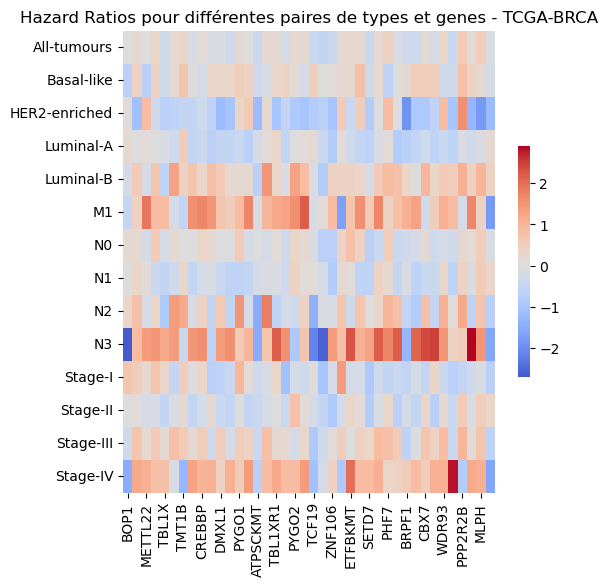

In [417]:
te = df_matrix_HR[df_matrix_HR.dataset == "TCGA_BRCA"].pivot("gene", "type", "HR").reset_index().iloc[np.argsort(HR_moy)[-50:]].set_index('gene').dropna(how='all')[
    df_matrix_HR[df_matrix_HR.dataset == "TCGA_BRCA"].pivot("gene", "type", "HR").reset_index().iloc[np.argsort(HR_moy)[-50:]].set_index('gene').dropna(how='all').apply(lambda x: (x <= 15).all(), axis=1)].T

plt.figure(figsize=(6, 6)) 
sns.heatmap(te,cmap="coolwarm", fmt=".2f",center = 0,cbar_kws={"shrink": 0.5})
plt.title(f"Hazard Ratios pour différentes paires de types et genes - TCGA-BRCA")
plt.xlabel('')
plt.ylabel('')
plt.show()

### Généralisation du travail fait ci-dessus avec un fonction

Dans cette fonction nous pourrons afficher la heatmap ci-dessus en choissant un dataset en entrée.

In [230]:
def matrixHR(dataset):
    HR_moy = []
    myDF = df_matrix_HR[df_matrix_HR.dataset == dataset]
    for index, row in myDF.pivot("gene", "type", "HR").reset_index().drop('gene', axis=1).iterrows():
        row_numeric = pd.to_numeric(row, errors='coerce')
        moy_abs = np.round(row_numeric.abs().mean(),2)
        HR_moy.append(moy_abs)
    top50 = np.argsort(HR_moy)[-50:]
    te = myDF.pivot("gene", "type", "HR").reset_index().iloc[top50].set_index('gene').dropna(how='all')[
        myDF.pivot("gene", "type", "HR").reset_index().iloc[top50].set_index('gene').dropna(how='all').apply(lambda x: (x <= 15).all(), axis=1)]
    
    plt.figure(figsize=(6, 6)) 
    ax = sns.heatmap(te,cmap="coolwarm", fmt=".2f",center = 0,cbar_kws={"shrink": 0.5})
    plt.title(f"Hazard Ratios pour différentes paires de types et genes - {dataset}")
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.xlabel('')
    plt.ylabel('')
    plt.show()

# Exemple d'utilisation 
matrixHR("TCGA_BRCA")

NameError: name 'df_matrix_HR' is not defined

In [229]:
matrixHR("GSE21653")
matrixHR("E-MTAB-365")
matrixHR('GSE25066')
matrixHR('GSE42568')
matrixHR('Yau-2010')

NameError: name 'matrixHR' is not defined

In [445]:
HR_moy = []
myDF = df_matrix_HR[df_matrix_HR.dataset == "GSE21653"]

Series([], Name: HR, dtype: int64)

# PS : LE PROBLEME CEST QUE JAI FAIT TOURNER GROS DF QUE POUR LES OS DUCOUP J4EN AI RELANCE UN POUR LES DFS (LE FAIRE TOURNER, IL MATTEND)

In [435]:
matrixHR("GSE21653")

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 600x600 with 0 Axes>